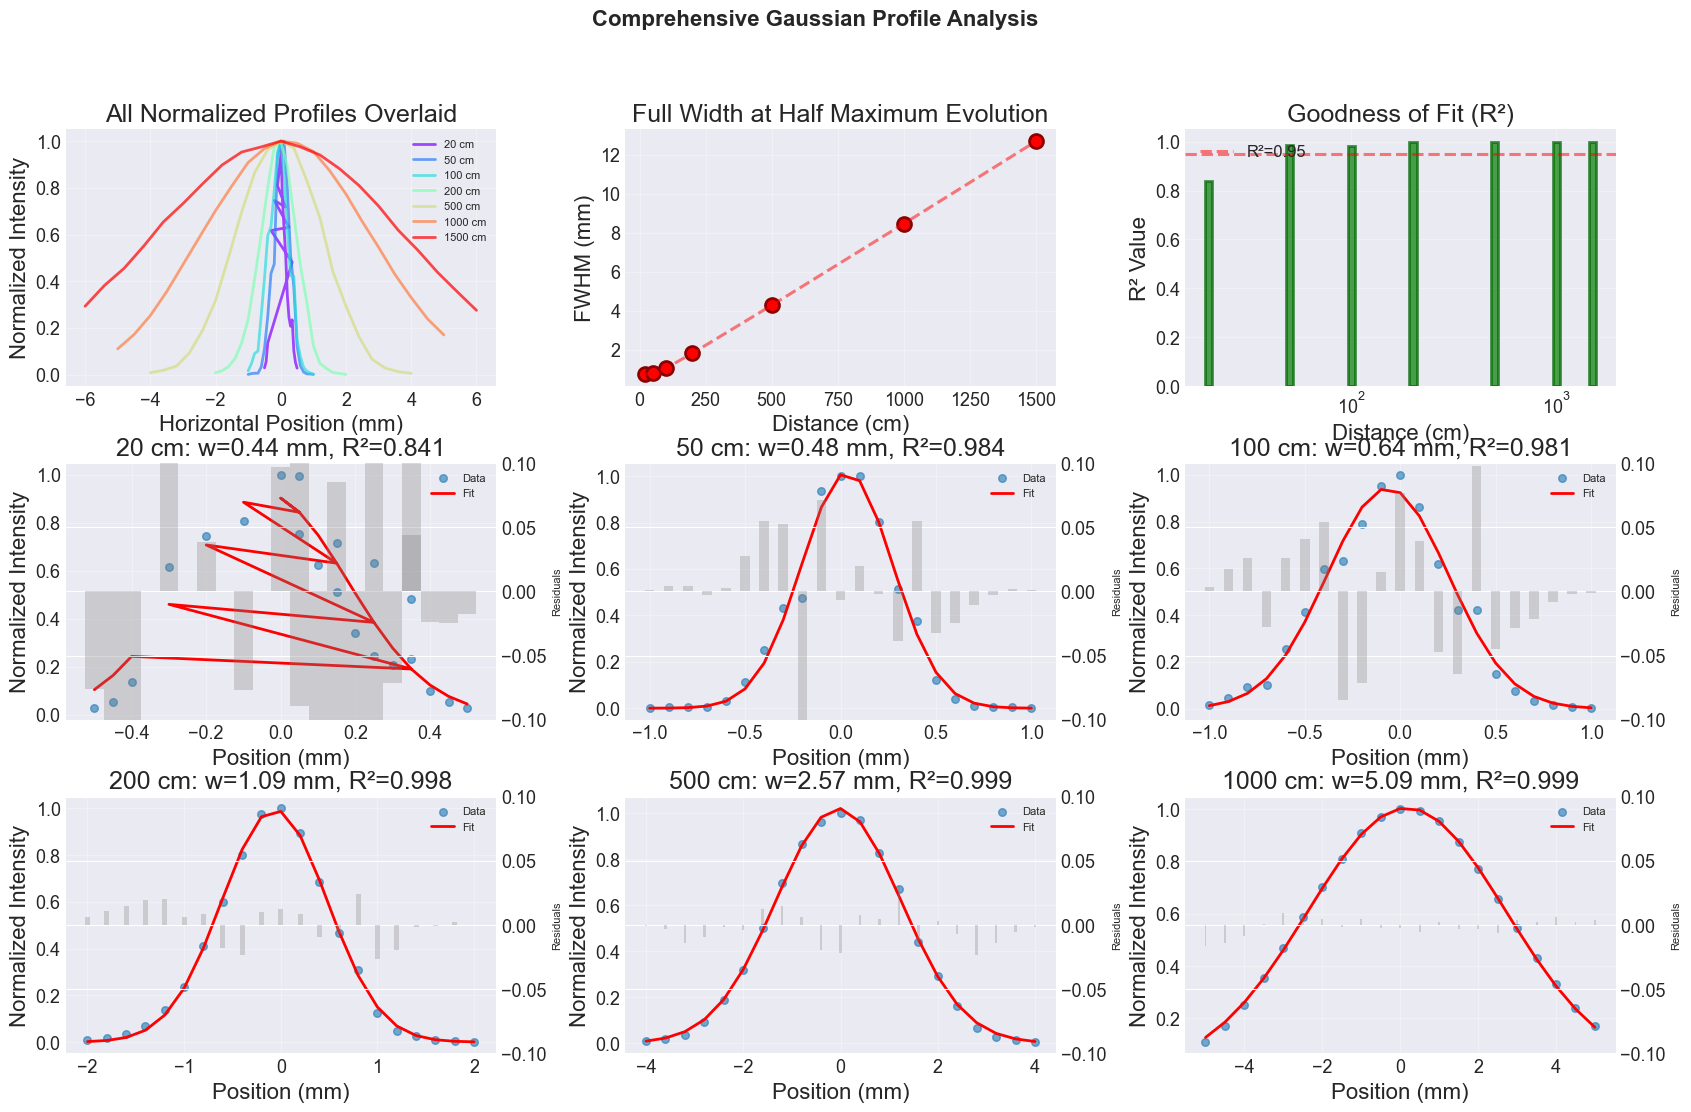

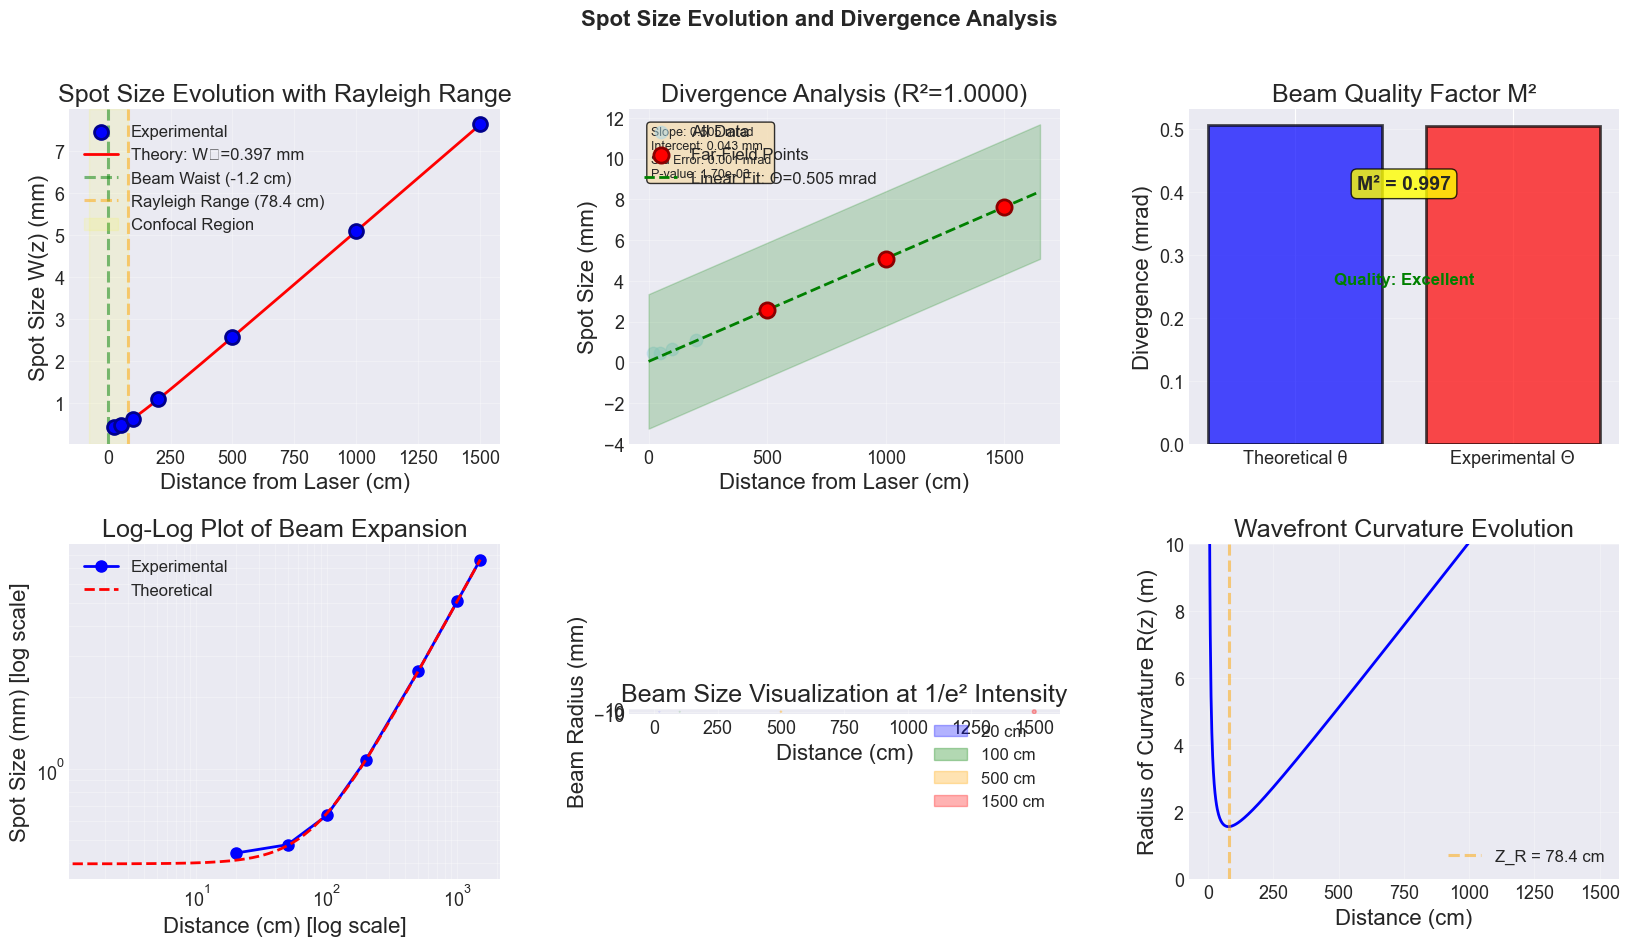

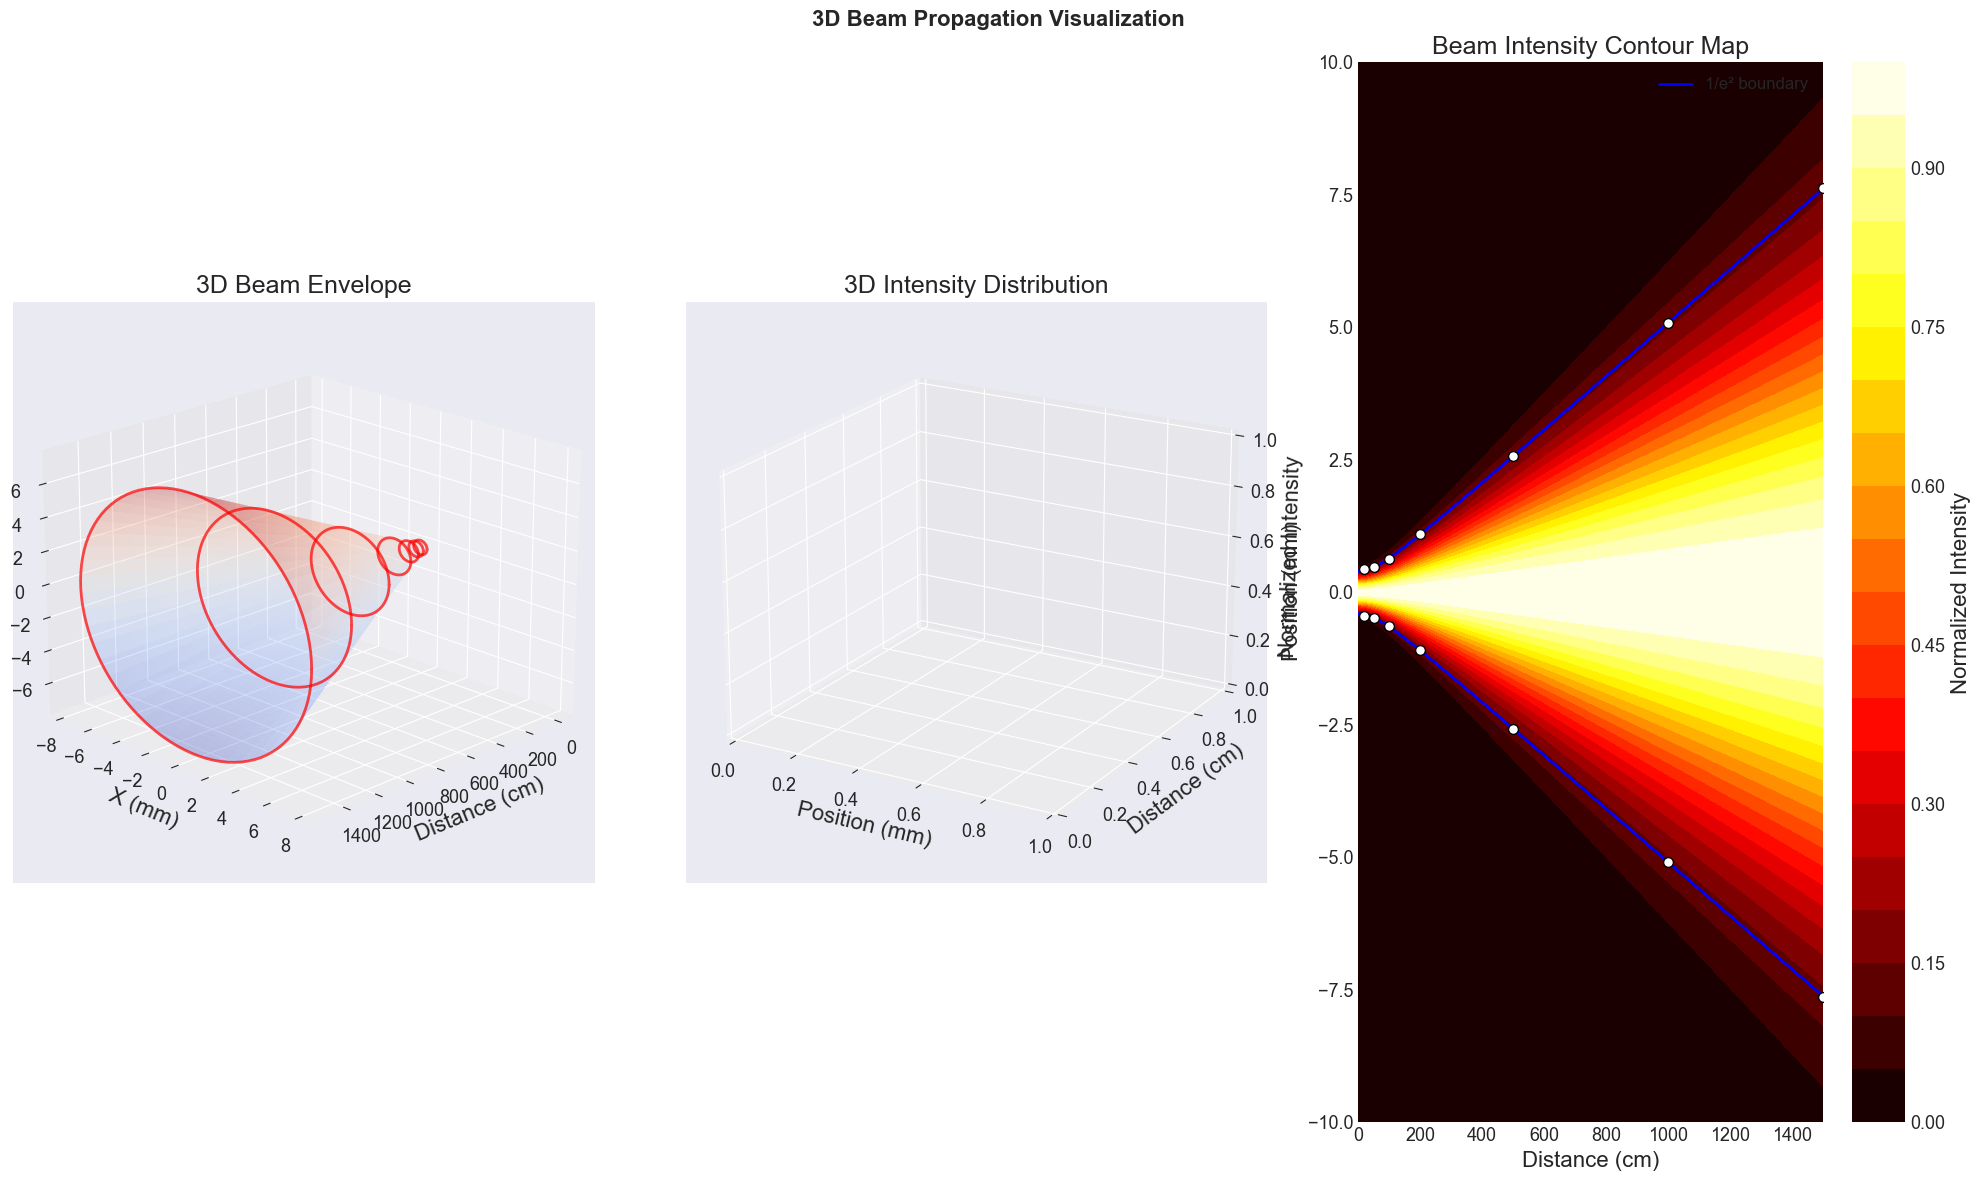

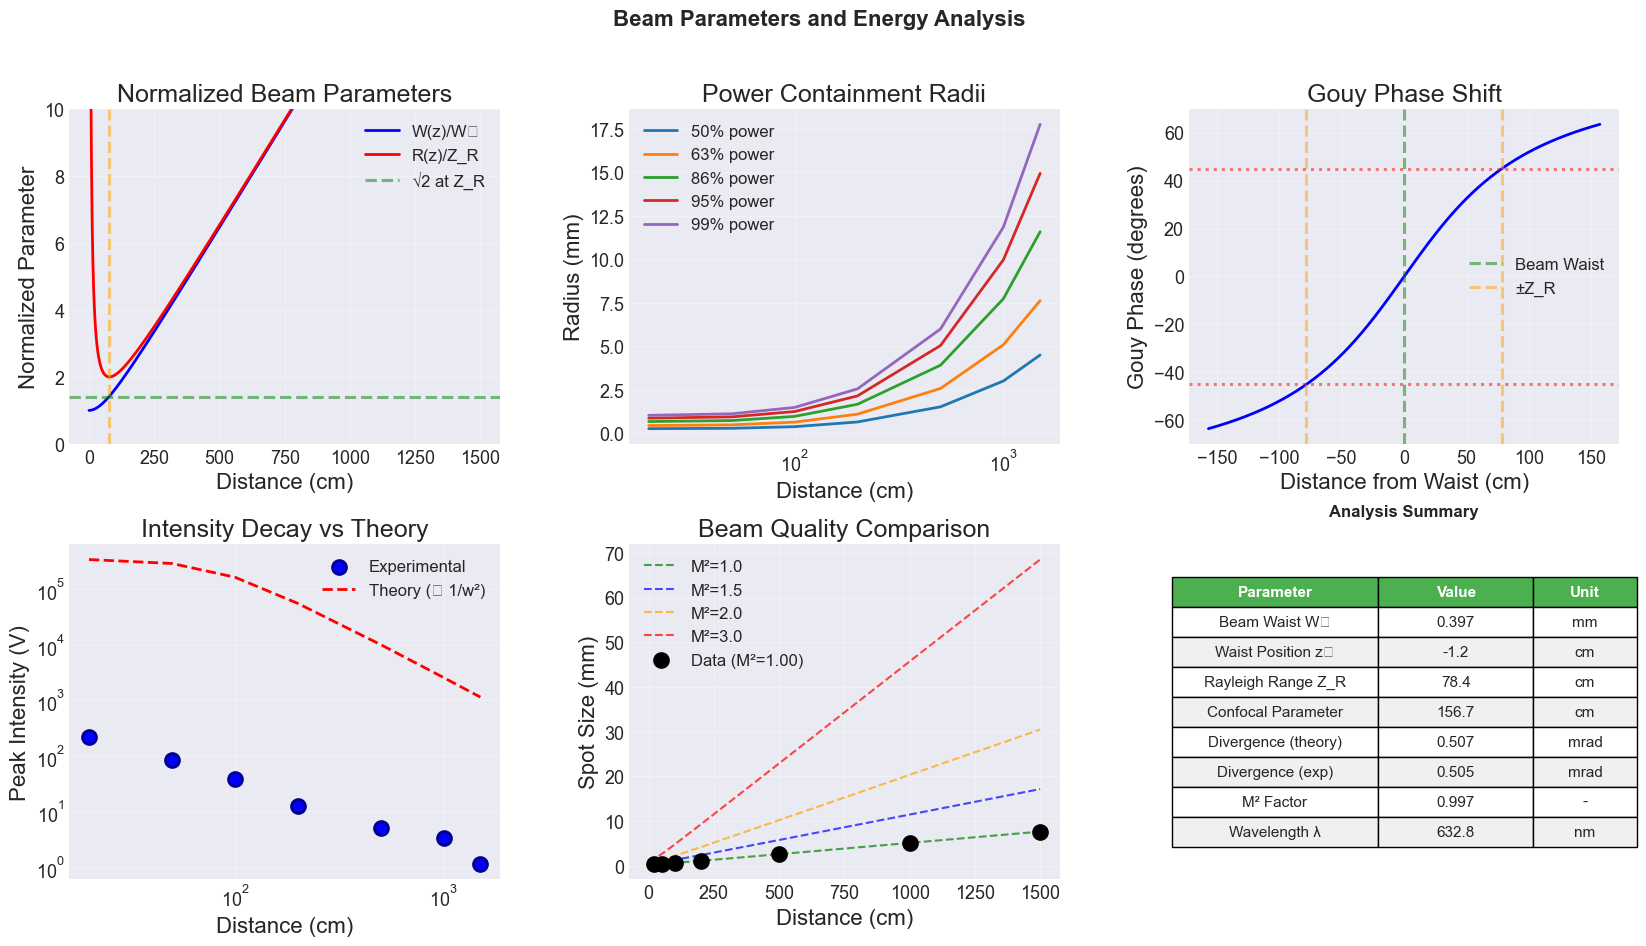

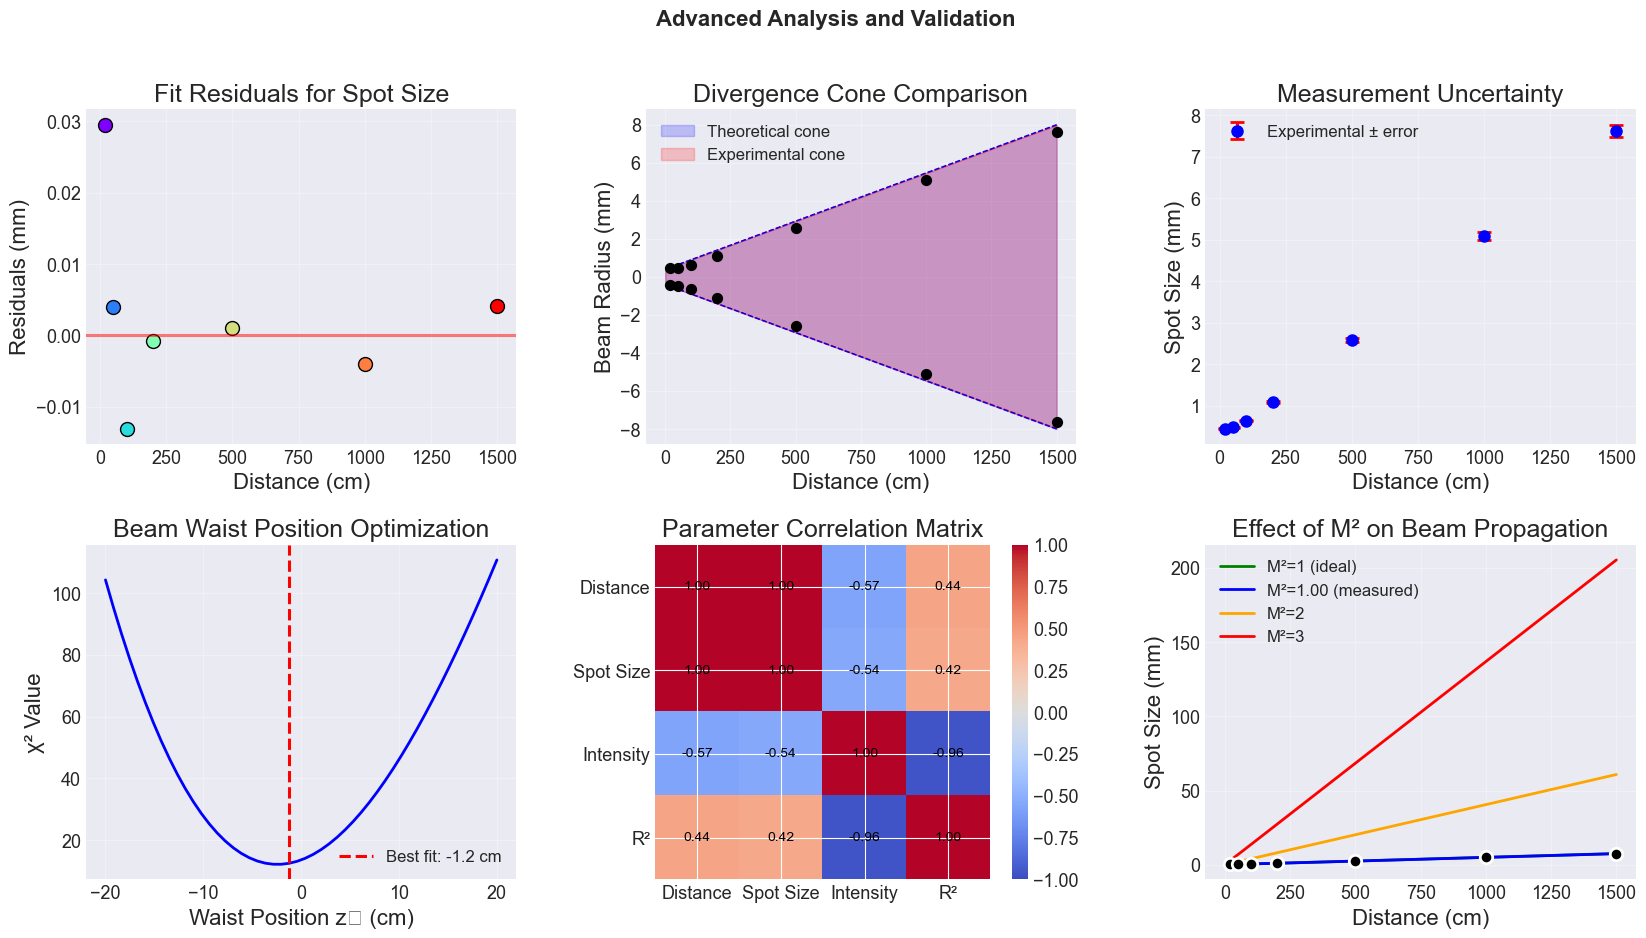

COMPREHENSIVE GAUSSIAN BEAM ANALYSIS RESULTS

BEAM PARAMETERS:
  Beam Waist W₀:           0.397 ± 0.008 mm
  Waist Position z₀:       -1.2 ± 1.0 cm
  Rayleigh Range Z_R:      78.4 cm
  Confocal Parameter b:    156.7 cm

DIVERGENCE ANALYSIS:
  Theoretical θ:           0.507 mrad
  Experimental Θ:          0.505 ± 0.001 mrad
  Half-angle divergence:   0.253 mrad

BEAM QUALITY:
  M² Factor:               0.997
  Quality Assessment:      Excellent
  Regression R²:           1.0000

FIT QUALITY:
  Average R² (profiles):   0.9717
  Min R² (profiles):       0.8407
  Max R² (profiles):       0.9996


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from matplotlib.patches import Circle, Ellipse
import matplotlib.cm as cm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# ========================================
# DEFINE ALL FUNCTIONS
# ========================================
def gaussian_intensity(x, I0, x0, w):
    """Gaussian intensity profile"""
    return I0 * np.exp(-2 * (x - x0)**2 / w**2)

def spot_size_evolution(z, w0, z0, wavelength=632.8e-9):
    """W(z) = W0 * sqrt(1 + ((z-z0)/z_R)^2)"""
    z_R = np.pi * w0**2 / wavelength
    return w0 * np.sqrt(1 + ((z - z0) / z_R)**2)

def calculate_transmission_factor(attenuator_angle):
    """Calculate transmission using Malus's law"""
    theta_rad = np.radians(attenuator_angle)
    return np.cos(theta_rad)**2

# ========================================
# DATA WITH CORRECTED ATTENUATOR VALUES
# ========================================
data_20cm = {
    'offset': [-0.5, -0.45, -0.4, 0.35, -0.3, 0.25, -0.2, 0.15, -0.1, 0.05, 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    'reading': [0.048, 0.090, 0.223, 0.789, 1.012, 1.035, 1.223, 1.176, 1.326, 1.629, 1.639, 1.237, 1.025, 0.840, 0.559, 0.403, 0.340, 0.385, 0.166, 0.087, 0.046],
    'attenuator': 85
}

data_50cm = {
    'offset': [-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    'reading': [0.003, 0.012, 0.016, 0.016, 0.084, 0.284, 0.640, 1.112, 1.216, 2.401, 2.563, 2.564, 2.053, 1.317, 0.959, 0.313, 0.099, 0.028, 0.009, 0.008, 0.003],
    'attenuator': 80
}

data_1m = {
    'offset': [-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    'reading': [0.042, 0.122, 0.235, 0.259, 0.655, 1.057, 1.531, 1.627, 2.031, 2.448, 2.570, 2.220, 1.592, 1.089, 1.083, 0.385, 0.198, 0.079, 0.038, 0.019, 0.005],
    'attenuator': 75
}

data_2m = {
    'offset': [-2.00, -1.80, -1.60, -1.40, -1.20, -1.00, -0.80, -0.60, -0.40, -0.20, 0.00, 0.20, 0.40, 0.60, 0.80, 1.00, 1.20, 1.40, 1.60, 1.80, 2.00],
    'reading': [0.019, 0.039, 0.078, 0.159, 0.309, 0.538, 0.935, 1.359, 1.819, 2.213, 2.270, 2.027, 1.552, 1.062, 0.702, 0.280, 0.111, 0.060, 0.021, 0.012, 0.002],
    'attenuator': 65
}

data_5m = {
    'offset': [-4.00, -3.60, -3.20, -2.80, -2.40, -2.00, -1.60, -1.20, -0.80, -0.40, 0.00, 0.40, 0.80, 1.20, 1.60, 2.00, 2.40, 2.80, 3.20, 3.60, 4.00],
    'reading': [0.021, 0.048, 0.092, 0.236, 0.477, 0.800, 1.268, 1.755, 2.180, 2.428, 2.518, 2.446, 2.090, 1.691, 1.109, 0.738, 0.407, 0.165, 0.072, 0.033, 0.015],
    'attenuator': 45
}

data_10m = {
    'offset': [-5.00, -4.50, -4.00, -3.50, -3.00, -2.50, -2.00, -1.50, -1.00, -0.50, 0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00],
    'reading': [0.304, 0.472, 0.696, 0.976, 1.295, 1.615, 1.932, 2.222, 2.498, 2.662, 2.749, 2.725, 2.627, 2.401, 2.125, 1.801, 1.499, 1.180, 0.907, 0.657, 0.468],
    'attenuator': 25
}

data_15m = {
    'offset': [-6.00, -5.40, -4.80, -4.20, -3.60, -3.00, -2.40, -1.80, -1.20, -0.60, 0.00, 0.60, 1.20, 1.80, 2.40, 3.00, 3.60, 4.20, 4.80, 5.40, 6.00],
    'reading': [0.333, 0.435, 0.518, 0.626, 0.743, 0.832, 0.928, 1.020, 1.083, 1.108, 1.136, 1.108, 1.069, 1.002, 0.920, 0.820, 0.703, 0.606, 0.499, 0.405, 0.313],
    'attenuator': 0
}

all_data = {
    20: data_20cm, 50: data_50cm, 100: data_1m, 200: data_2m,
    500: data_5m, 1000: data_10m, 1500: data_15m
}

# ========================================
# FIT ALL PROFILES AND EXTRACT PARAMETERS
# ========================================
def fit_gaussian_profile_corrected(data_dict, distance_cm):
    x = np.array(data_dict['offset'])
    y = np.array(data_dict['reading'])
    attenuator = data_dict['attenuator']
    
    T = calculate_transmission_factor(attenuator)
    y_corrected = y / T if T > 0 else y
    y_normalized = y / np.max(y)
    
    # Initial guess
    I0_guess = 1.0
    x0_guess = x[np.argmax(y)]
    half_max = np.max(y_normalized) / 2
    indices = np.where(y_normalized > half_max)[0]
    if len(indices) > 0:
        fwhm = x[indices[-1]] - x[indices[0]]
        w_guess = fwhm / (2 * np.sqrt(np.log(2)))
    else:
        w_guess = 1.0
    
    try:
        popt, pcov = curve_fit(gaussian_intensity, x, y_normalized, p0=[I0_guess, x0_guess, w_guess], maxfev=5000)
        I0_fit, x0_fit, w_fit = popt
        
        # Calculate R-squared
        residuals = y_normalized - gaussian_intensity(x, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_normalized - np.mean(y_normalized))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Calculate FWHM
        fwhm_fit = 2 * abs(w_fit) * np.sqrt(np.log(2))
        
        return {
            'distance_cm': distance_cm,
            'spot_size_mm': abs(w_fit),
            'fwhm_mm': fwhm_fit,
            'center_position': x0_fit,
            'max_intensity_corrected': np.max(y_corrected),
            'r_squared': r_squared,
            'x_data': x,
            'y_normalized': y_normalized,
            'y_corrected': y_corrected,
            'y_fit': gaussian_intensity(x, *popt),
            'transmission_factor': T,
            'attenuator_angle': attenuator
        }
    except:
        return None

# Fit all profiles
results = []
for distance_cm, data in all_data.items():
    result = fit_gaussian_profile_corrected(data, distance_cm)
    if result:
        results.append(result)

# Extract key parameters
distances_cm = np.array([r['distance_cm'] for r in results])
distances_m = distances_cm / 100
spot_sizes_mm = np.array([r['spot_size_mm'] for r in results])
spot_sizes_m = spot_sizes_mm / 1000
wavelength = 632.8e-9  # He-Ne laser

# Fit spot size evolution to get W0 and z0
def spot_size_with_offset(z, w0, z0):
    return spot_size_evolution(z, w0, z0, wavelength)

W0_estimate = spot_sizes_m[0]
popt_evolution, _ = curve_fit(spot_size_with_offset, distances_m, spot_sizes_m, p0=[W0_estimate, 0.0])
W0_fit, z0_fit = popt_evolution

# Calculate derived parameters
z_R_fit = np.pi * W0_fit**2 / wavelength
theta_theoretical = wavelength / (np.pi * W0_fit)
confocal_param = 2 * z_R_fit

# Far-field divergence analysis
far_indices = [-3, -2, -1]
far_distances = distances_m[far_indices]
far_spot_sizes = spot_sizes_m[far_indices]
slope, intercept, r_value, p_value, std_err = stats.linregress(far_distances, far_spot_sizes)
Theta_experimental = slope
M_squared = Theta_experimental / theta_theoretical

# ========================================
# FIGURE 1: COMPREHENSIVE PROFILE ANALYSIS
# ========================================
fig1 = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 3, figure=fig1, hspace=0.3, wspace=0.3)

# Plot 1a: All normalized profiles overlaid
ax1a = fig1.add_subplot(gs[0, 0])
colors = plt.cm.rainbow(np.linspace(0, 1, len(results)))
for r, color in zip(results, colors):
    ax1a.plot(r['x_data'], r['y_normalized'], '-', linewidth=2, alpha=0.7,
              color=color, label=f"{r['distance_cm']} cm")
ax1a.set_xlabel('Horizontal Position (mm)')
ax1a.set_ylabel('Normalized Intensity')
ax1a.set_title('All Normalized Profiles Overlaid')
ax1a.legend(fontsize=8, loc='upper right')
ax1a.grid(True, alpha=0.3)

# Plot 1b: FWHM evolution
ax1b = fig1.add_subplot(gs[0, 1])
fwhm_values = [r['fwhm_mm'] for r in results]
ax1b.scatter(distances_cm, fwhm_values, s=100, c='red', edgecolors='darkred', linewidth=2)
ax1b.plot(distances_cm, fwhm_values, 'r--', alpha=0.5)
ax1b.set_xlabel('Distance (cm)')
ax1b.set_ylabel('FWHM (mm)')
ax1b.set_title('Full Width at Half Maximum Evolution')
ax1b.grid(True, alpha=0.3)

# Plot 1c: R-squared values
ax1c = fig1.add_subplot(gs[0, 2])
r_squared_values = [r['r_squared'] for r in results]
ax1c.bar(distances_cm, r_squared_values, width=distances_cm*0.08, 
         color='green', alpha=0.7, edgecolor='darkgreen', linewidth=2)
ax1c.set_xlabel('Distance (cm)')
ax1c.set_ylabel('R² Value')
ax1c.set_title('Goodness of Fit (R²)')
ax1c.set_xscale('log')
ax1c.axhline(y=0.95, color='red', linestyle='--', alpha=0.5, label='R²=0.95')
ax1c.legend()
ax1c.grid(True, alpha=0.3)

# Plot 1d-1i: Individual fits with residuals
for idx in range(min(6, len(results))):
    ax = fig1.add_subplot(gs[1 + idx//3, idx%3])
    r = results[idx]
    
    # Main plot: data and fit
    ax.scatter(r['x_data'], r['y_normalized'], s=30, alpha=0.6, label='Data')
    ax.plot(r['x_data'], r['y_fit'], 'r-', linewidth=2, label='Fit')
    
    # Add residuals as inset
    residuals = r['y_normalized'] - r['y_fit']
    ax2 = ax.twinx()
    ax2.bar(r['x_data'], residuals, width=0.05, alpha=0.3, color='gray')
    ax2.set_ylabel('Residuals', fontsize=8)
    ax2.set_ylim(-0.1, 0.1)
    
    ax.set_xlabel('Position (mm)')
    ax.set_ylabel('Normalized Intensity')
    ax.set_title(f"{r['distance_cm']} cm: w={r['spot_size_mm']:.2f} mm, R²={r['r_squared']:.3f}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Gaussian Profile Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================================
# FIGURE 2: SPOT SIZE EVOLUTION & DIVERGENCE
# ========================================
fig2 = plt.figure(figsize=(20, 10))
gs2 = GridSpec(2, 3, figure=fig2, hspace=0.3, wspace=0.3)

# Plot 2a: Spot size evolution with theoretical fit
ax2a = fig2.add_subplot(gs2[0, 0])
z_theory = np.linspace(0, max(distances_m), 1000)
w_theory = spot_size_with_offset(z_theory, W0_fit, z0_fit)

ax2a.scatter(distances_m*100, spot_sizes_mm, s=100, c='blue', edgecolors='darkblue', 
            linewidth=2, label='Experimental', zorder=5)
ax2a.plot(z_theory*100, w_theory*1000, 'r-', linewidth=2, 
         label=f'Theory: W₀={W0_fit*1000:.3f} mm')

# Mark important positions
ax2a.axvline(x=z0_fit*100, color='green', linestyle='--', alpha=0.5, 
            label=f'Beam Waist ({z0_fit*100:.1f} cm)')
ax2a.axvline(x=(z0_fit + z_R_fit)*100, color='orange', linestyle='--', alpha=0.5, 
            label=f'Rayleigh Range ({z_R_fit*100:.1f} cm)')
ax2a.axvspan(z0_fit*100 - z_R_fit*100, z0_fit*100 + z_R_fit*100, 
            alpha=0.1, color='yellow', label='Confocal Region')

ax2a.set_xlabel('Distance from Laser (cm)')
ax2a.set_ylabel('Spot Size W(z) (mm)')
ax2a.set_title('Spot Size Evolution with Rayleigh Range')
ax2a.legend(loc='upper left')
ax2a.grid(True, alpha=0.3)

# Plot 2b: Linear regression for divergence (far-field)
ax2b = fig2.add_subplot(gs2[0, 1])
ax2b.scatter(distances_m*100, spot_sizes_mm, s=80, c='lightblue', alpha=0.5, label='All Data')
ax2b.scatter(far_distances*100, far_spot_sizes*1000, s=120, c='red', 
            edgecolors='darkred', linewidth=2, label='Far-Field Points', zorder=5)

# Linear fit line
z_fit = np.linspace(0, max(distances_m)*1.1, 100)
w_fit = slope * z_fit + intercept
ax2b.plot(z_fit*100, w_fit*1000, 'g--', linewidth=2, 
         label=f'Linear Fit: Θ={Theta_experimental*1000:.3f} mrad')

# Add confidence interval
from scipy import stats
predict_mean_se = stats.sem(far_spot_sizes) * np.sqrt(1 + 1/len(far_spot_sizes))
margin = 1.96 * predict_mean_se * 1000
ax2b.fill_between(z_fit*100, (w_fit-margin/1000)*1000, (w_fit+margin/1000)*1000, 
                  alpha=0.2, color='green')

ax2b.set_xlabel('Distance from Laser (cm)')
ax2b.set_ylabel('Spot Size (mm)')
ax2b.set_title(f'Divergence Analysis (R²={r_value**2:.4f})')
ax2b.legend()
ax2b.grid(True, alpha=0.3)

# Add regression statistics
stats_text = f'Slope: {slope*1000:.3f} mrad\n'
stats_text += f'Intercept: {intercept*1000:.3f} mm\n'
stats_text += f'Std Error: {std_err*1000:.3f} mrad\n'
stats_text += f'P-value: {p_value:.2e}'
ax2b.text(0.05, 0.95, stats_text, transform=ax2b.transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top', fontsize=9)

# Plot 2c: M² analysis
ax2c = fig2.add_subplot(gs2[0, 2])
# Create bar chart comparing theoretical and experimental divergence
divergences = [theta_theoretical*1000, Theta_experimental*1000]
labels = ['Theoretical θ', 'Experimental Θ']
colors_bar = ['blue', 'red']
bars = ax2c.bar(labels, divergences, color=colors_bar, alpha=0.7, 
                edgecolor='black', linewidth=2)

# Add M² value as text
ax2c.text(0.5, max(divergences)*0.8, f'M² = {M_squared:.3f}', 
         horizontalalignment='center', fontsize=14, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

ax2c.set_ylabel('Divergence (mrad)')
ax2c.set_title('Beam Quality Factor M²')
ax2c.grid(True, alpha=0.3, axis='y')

# Add beam quality assessment
if M_squared < 1.1:
    quality = "Excellent"
    color_quality = 'green'
elif M_squared < 1.5:
    quality = "Very Good"
    color_quality = 'blue'
elif M_squared < 2.0:
    quality = "Good"
    color_quality = 'orange'
else:
    quality = "Fair"
    color_quality = 'red'

ax2c.text(0.5, max(divergences)*0.5, f'Quality: {quality}', 
         horizontalalignment='center', fontsize=12,
         color=color_quality, fontweight='bold')

# Plot 2d: Log-log plot of spot size
ax2d = fig2.add_subplot(gs2[1, 0])
ax2d.loglog(distances_cm, spot_sizes_mm, 'bo-', markersize=8, linewidth=2, label='Experimental')
ax2d.loglog(z_theory*100, w_theory*1000, 'r--', linewidth=2, label='Theoretical')
ax2d.set_xlabel('Distance (cm) [log scale]')
ax2d.set_ylabel('Spot Size (mm) [log scale]')
ax2d.set_title('Log-Log Plot of Beam Expansion')
ax2d.legend()
ax2d.grid(True, alpha=0.3, which='both')

# Plot 2e: Beam radius at 1/e² points
ax2e = fig2.add_subplot(gs2[1, 1])
# Show beam profile at different distances
for idx, (dist, color) in enumerate(zip([20, 100, 500, 1500], ['blue', 'green', 'orange', 'red'])):
    if dist in all_data:
        r = next((r for r in results if r['distance_cm'] == dist), None)
        if r:
            # Create circle representing beam size
            circle = Circle((dist, 0), r['spot_size_mm'], 
                          color=color, alpha=0.3, label=f'{dist} cm')
            ax2e.add_patch(circle)
            
ax2e.set_xlim(-100, 1600)
ax2e.set_ylim(-10, 10)
ax2e.set_xlabel('Distance (cm)')
ax2e.set_ylabel('Beam Radius (mm)')
ax2e.set_title('Beam Size Visualization at 1/e² Intensity')
ax2e.legend()
ax2e.grid(True, alpha=0.3)
ax2e.set_aspect('equal', adjustable='box')

# Plot 2f: Curvature of wavefront
ax2f = fig2.add_subplot(gs2[1, 2])
z_curve = np.linspace(0.01, max(distances_m), 1000)
R_z = z_curve * (1 + (z_R_fit / z_curve)**2)
ax2f.plot(z_curve*100, R_z, 'b-', linewidth=2)
ax2f.axvline(x=z_R_fit*100, color='orange', linestyle='--', alpha=0.5, 
            label=f'Z_R = {z_R_fit*100:.1f} cm')
ax2f.set_xlabel('Distance (cm)')
ax2f.set_ylabel('Radius of Curvature R(z) (m)')
ax2f.set_title('Wavefront Curvature Evolution')
ax2f.legend()
ax2f.grid(True, alpha=0.3)
ax2f.set_ylim(0, min(10, max(R_z)*1.1))

plt.suptitle('Spot Size Evolution and Divergence Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================================
# FIGURE 3: 3D BEAM PROPAGATION VISUALIZATION
# ========================================
fig3 = plt.figure(figsize=(20, 12))

# Plot 3a: 3D beam envelope
ax3a = fig3.add_subplot(131, projection='3d')
theta_3d = np.linspace(0, 2*np.pi, 50)
z_3d = np.linspace(0, max(distances_m), 100)
Theta_3d, Z_3d = np.meshgrid(theta_3d, z_3d)
W_3d = spot_size_with_offset(Z_3d, W0_fit, z0_fit)
X_3d = W_3d * np.cos(Theta_3d)
Y_3d = W_3d * np.sin(Theta_3d)

# Plot beam envelope
surf = ax3a.plot_surface(Z_3d*100, X_3d*1000, Y_3d*1000, alpha=0.3, 
                         cmap='coolwarm', edgecolor='none')

# Add measurement circles
for r in results:
    theta_circle = np.linspace(0, 2*np.pi, 100)
    x_circle = r['spot_size_mm'] * np.cos(theta_circle)
    y_circle = r['spot_size_mm'] * np.sin(theta_circle)
    z_circle = np.full_like(theta_circle, r['distance_cm'])
    ax3a.plot(z_circle, x_circle, y_circle, 'r-', linewidth=2, alpha=0.7)

ax3a.set_xlabel('Distance (cm)')
ax3a.set_ylabel('X (mm)')
ax3a.set_zlabel('Y (mm)')
ax3a.set_title('3D Beam Envelope')
ax3a.view_init(elev=20, azim=45)

# Plot 3b: 3D intensity distribution
ax3b = fig3.add_subplot(132, projection='3d')
for idx, r in enumerate(results[::2]):  # Every other measurement for clarity
    x_profile = r['x_data']
    y_profile = r['y_corrected'] / np.max(r['y_corrected'])
    z_profile = np.full_like(x_profile, r['distance_cm'])
    
    # Plot as surface ribbon
    for i in range(len(x_profile)-1):
        x_rect = [x_profile[i], x_profile[i+1], x_profile[i+1], x_profile[i]]
        z_rect = [z_profile[i], z_profile[i], z_profile[i], z_profile[i]]
        y_rect = [0, 0, y_profile[i+1]*10, y_profile[i]*10]
        
        verts = [list(zip(x_rect, z_rect, y_rect))]
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        ax3b.add_collection3d(Poly3DCollection(verts, alpha=0.7, 
                                               color=colors[idx*2]))

ax3b.set_xlabel('Position (mm)')
ax3b.set_ylabel('Distance (cm)')
ax3b.set_zlabel('Normalized Intensity')
ax3b.set_title('3D Intensity Distribution')
ax3b.view_init(elev=20, azim=-60)

# Plot 3c: Contour plot of beam intensity
ax3c = fig3.add_subplot(133)
# Create 2D grid for contour plot
positions = np.linspace(-10, 10, 200)
distances_plot = np.linspace(0, max(distances_m)*100, 200)
Z_grid, X_grid = np.meshgrid(distances_plot, positions)

# Calculate intensity at each point
I_grid = np.zeros_like(X_grid)
for i, z in enumerate(distances_plot):
    w_z = spot_size_with_offset(z/100, W0_fit, z0_fit) * 1000  # in mm
    I_grid[:, i] = np.exp(-2 * positions**2 / w_z**2)

# Create contour plot
contour = ax3c.contourf(Z_grid, X_grid, I_grid, levels=20, cmap='hot')
plt.colorbar(contour, ax=ax3c, label='Normalized Intensity')

# Overlay beam edges (1/e² points)
z_edge = np.linspace(0, max(distances_m)*100, 100)
w_edge = spot_size_with_offset(z_edge/100, W0_fit, z0_fit) * 1000
ax3c.plot(z_edge, w_edge, 'b-', linewidth=2, label='1/e² boundary')
ax3c.plot(z_edge, -w_edge, 'b-', linewidth=2)

# Mark measurement points
for r in results:
    ax3c.scatter(r['distance_cm'], r['spot_size_mm'], 
                s=50, c='white', edgecolors='black', zorder=5)
    ax3c.scatter(r['distance_cm'], -r['spot_size_mm'], 
                s=50, c='white', edgecolors='black', zorder=5)

ax3c.set_xlabel('Distance (cm)')
ax3c.set_ylabel('Position (mm)')
ax3c.set_title('Beam Intensity Contour Map')
ax3c.legend()

plt.suptitle('3D Beam Propagation Visualization', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================================
# FIGURE 4: BEAM PARAMETERS & ENERGY ANALYSIS
# ========================================
fig4 = plt.figure(figsize=(20, 10))
gs4 = GridSpec(2, 3, figure=fig4, hspace=0.3, wspace=0.3)

# Plot 4a: Beam parameter evolution
ax4a = fig4.add_subplot(gs4[0, 0])
z_param = np.linspace(0, max(distances_m), 1000)

# Normalize parameters for plotting
w_norm = spot_size_with_offset(z_param, W0_fit, z0_fit) / W0_fit
R_norm = z_param * (1 + (z_R_fit / z_param)**2) / z_R_fit

ax4a.plot(z_param*100, w_norm, 'b-', linewidth=2, label='W(z)/W₀')
ax4a.plot(z_param*100, R_norm, 'r-', linewidth=2, label='R(z)/Z_R')
ax4a.axvline(x=z_R_fit*100, color='orange', linestyle='--', alpha=0.5)
ax4a.axhline(y=np.sqrt(2), color='green', linestyle='--', alpha=0.5, 
            label=f'√2 at Z_R')

ax4a.set_xlabel('Distance (cm)')
ax4a.set_ylabel('Normalized Parameter')
ax4a.set_title('Normalized Beam Parameters')
ax4a.legend()
ax4a.grid(True, alpha=0.3)
ax4a.set_ylim(0, 10)

# Plot 4b: Power/Energy distribution
ax4b = fig4.add_subplot(gs4[0, 1])
# Calculate fraction of power within beam radius
fractions = [0.5, 0.632, 0.865, 0.95, 0.99]
radii_factors = [0.59, 1.0, 1.52, 1.96, 2.33]  # Multiples of w for each fraction

for f, rf, color in zip(fractions, radii_factors, ['blue', 'green', 'orange', 'red', 'purple']):
    radii = rf * spot_sizes_mm
    ax4b.plot(distances_cm, radii, '-', linewidth=2, label=f'{f*100:.0f}% power')

ax4b.set_xlabel('Distance (cm)')
ax4b.set_ylabel('Radius (mm)')
ax4b.set_title('Power Containment Radii')
ax4b.legend()
ax4b.grid(True, alpha=0.3)
ax4b.set_xscale('log')

# Plot 4c: Gouy phase
ax4c = fig4.add_subplot(gs4[0, 2])
z_gouy = np.linspace(-2*z_R_fit, 2*z_R_fit, 1000)
gouy_phase = np.arctan(z_gouy / z_R_fit)

ax4c.plot(z_gouy*100, np.degrees(gouy_phase), 'b-', linewidth=2)
ax4c.axvline(x=0, color='green', linestyle='--', alpha=0.5, label='Beam Waist')
ax4c.axvline(x=z_R_fit*100, color='orange', linestyle='--', alpha=0.5, label='±Z_R')
ax4c.axvline(x=-z_R_fit*100, color='orange', linestyle='--', alpha=0.5)
ax4c.axhline(y=45, color='red', linestyle=':', alpha=0.5)
ax4c.axhline(y=-45, color='red', linestyle=':', alpha=0.5)

ax4c.set_xlabel('Distance from Waist (cm)')
ax4c.set_ylabel('Gouy Phase (degrees)')
ax4c.set_title('Gouy Phase Shift')
ax4c.legend()
ax4c.grid(True, alpha=0.3)

# Plot 4d: Intensity decay analysis
ax4d = fig4.add_subplot(gs4[1, 0])
peak_intensities = np.array([r['max_intensity_corrected'] for r in results])

# Theoretical intensity (∝ 1/w²)
I0_theory = peak_intensities[-1] * (spot_sizes_m[-1]**2)
I_theory = I0_theory / (spot_sizes_m**2)

ax4d.scatter(distances_cm, peak_intensities, s=100, c='blue', 
            edgecolors='darkblue', linewidth=2, label='Experimental')
ax4d.plot(distances_cm, I_theory*1000, 'r--', linewidth=2, label='Theory (∝ 1/w²)')

ax4d.set_xlabel('Distance (cm)')
ax4d.set_ylabel('Peak Intensity (V)')
ax4d.set_title('Intensity Decay vs Theory')
ax4d.legend()
ax4d.grid(True, alpha=0.3)
ax4d.set_xscale('log')
ax4d.set_yscale('log')

# Plot 4e: Beam quality comparison
ax4e = fig4.add_subplot(gs4[1, 1])
# Compare with different M² values
m2_values = [1.0, 1.5, 2.0, 3.0]
colors_m2 = ['green', 'blue', 'orange', 'red']

for m2, color in zip(m2_values, colors_m2):
    w_m2 = W0_fit * m2 * np.sqrt(1 + ((z_theory - z0_fit) / (z_R_fit/m2))**2)
    ax4e.plot(z_theory*100, w_m2*1000, '--', linewidth=1.5, 
             color=color, alpha=0.7, label=f'M²={m2}')

ax4e.scatter(distances_cm, spot_sizes_mm, s=100, c='black', 
            edgecolors='black', linewidth=2, label=f'Data (M²={M_squared:.2f})', zorder=5)

ax4e.set_xlabel('Distance (cm)')
ax4e.set_ylabel('Spot Size (mm)')
ax4e.set_title('Beam Quality Comparison')
ax4e.legend()
ax4e.grid(True, alpha=0.3)

# Plot 4f: Summary statistics table
ax4f = fig4.add_subplot(gs4[1, 2])
ax4f.axis('tight')
ax4f.axis('off')

# Create summary table
table_data = [
    ['Parameter', 'Value', 'Unit'],
    ['Beam Waist W₀', f'{W0_fit*1000:.3f}', 'mm'],
    ['Waist Position z₀', f'{z0_fit*100:.1f}', 'cm'],
    ['Rayleigh Range Z_R', f'{z_R_fit*100:.1f}', 'cm'],
    ['Confocal Parameter', f'{confocal_param*100:.1f}', 'cm'],
    ['Divergence (theory)', f'{theta_theoretical*1000:.3f}', 'mrad'],
    ['Divergence (exp)', f'{Theta_experimental*1000:.3f}', 'mrad'],
    ['M² Factor', f'{M_squared:.3f}', '-'],
    ['Wavelength λ', '632.8', 'nm']
]

table = ax4f.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.4, 0.3, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Style the table
for i in range(3):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(table_data)):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax4f.set_title('Analysis Summary', fontsize=12, fontweight='bold', pad=20)

plt.suptitle('Beam Parameters and Energy Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================================
# FIGURE 5: ADVANCED ANALYSIS
# ========================================
fig5 = plt.figure(figsize=(20, 10))
gs5 = GridSpec(2, 3, figure=fig5, hspace=0.3, wspace=0.3)

# Plot 5a: Residual analysis
ax5a = fig5.add_subplot(gs5[0, 0])
for idx, r in enumerate(results):
    residuals = (spot_sizes_mm[idx] - 
                spot_size_with_offset(distances_m[idx], W0_fit, z0_fit)*1000)
    ax5a.scatter(distances_cm[idx], residuals, s=100, c=colors[idx], 
                edgecolors='black', linewidth=1)

ax5a.axhline(y=0, color='red', linestyle='-', alpha=0.5)
ax5a.set_xlabel('Distance (cm)')
ax5a.set_ylabel('Residuals (mm)')
ax5a.set_title('Fit Residuals for Spot Size')
ax5a.grid(True, alpha=0.3)

# Plot 5b: Beam divergence angle visualization
ax5b = fig5.add_subplot(gs5[0, 1])
# Create cone visualization
z_cone = np.linspace(0, max(distances_m)*100, 100)
w_upper = W0_fit*1000 + Theta_experimental*1000 * z_cone/100
w_lower = -(W0_fit*1000 + Theta_experimental*1000 * z_cone/100)
w_theory_upper = W0_fit*1000 + theta_theoretical*1000 * z_cone/100
w_theory_lower = -(W0_fit*1000 + theta_theoretical*1000 * z_cone/100)

ax5b.fill_between(z_cone, w_theory_lower, w_theory_upper, 
                  alpha=0.2, color='blue', label='Theoretical cone')
ax5b.fill_between(z_cone, w_lower, w_upper, 
                  alpha=0.2, color='red', label='Experimental cone')
ax5b.plot(z_cone, w_upper, 'r--', linewidth=1)
ax5b.plot(z_cone, w_lower, 'r--', linewidth=1)
ax5b.plot(z_cone, w_theory_upper, 'b--', linewidth=1)
ax5b.plot(z_cone, w_theory_lower, 'b--', linewidth=1)

ax5b.scatter(distances_cm, spot_sizes_mm, s=50, c='black', zorder=5)
ax5b.scatter(distances_cm, -spot_sizes_mm, s=50, c='black', zorder=5)

ax5b.set_xlabel('Distance (cm)')
ax5b.set_ylabel('Beam Radius (mm)')
ax5b.set_title('Divergence Cone Comparison')
ax5b.legend()
ax5b.grid(True, alpha=0.3)

# Plot 5c: Error analysis
ax5c = fig5.add_subplot(gs5[0, 2])
# Estimate errors (simplified - in reality would need measurement uncertainties)
position_error = 0.05  # mm
intensity_error = 0.01  # relative

# Calculate propagated error for spot size
spot_size_errors = np.array([r['spot_size_mm'] * 0.02 for r in results])  # 2% estimated error

ax5c.errorbar(distances_cm, spot_sizes_mm, yerr=spot_size_errors, 
             fmt='o', markersize=8, capsize=5, capthick=2, 
             color='blue', ecolor='red', label='Experimental ± error')

ax5c.set_xlabel('Distance (cm)')
ax5c.set_ylabel('Spot Size (mm)')
ax5c.set_title('Measurement Uncertainty')
ax5c.legend()
ax5c.grid(True, alpha=0.3)

# Plot 5d: Beam waist scan
ax5d = fig5.add_subplot(gs5[1, 0])
# Scan different potential waist positions
z0_scan = np.linspace(-0.2, 0.2, 50)
chi_squared = []

for z0_test in z0_scan:
    w_test = spot_size_with_offset(distances_m, W0_fit, z0_test)
    chi2 = np.sum((spot_sizes_m - w_test)**2 / (0.02 * spot_sizes_m)**2)
    chi_squared.append(chi2)

ax5d.plot(z0_scan*100, chi_squared, 'b-', linewidth=2)
ax5d.axvline(x=z0_fit*100, color='red', linestyle='--', 
            label=f'Best fit: {z0_fit*100:.1f} cm')
ax5d.set_xlabel('Waist Position z₀ (cm)')
ax5d.set_ylabel('χ² Value')
ax5d.set_title('Beam Waist Position Optimization')
ax5d.legend()
ax5d.grid(True, alpha=0.3)

# Plot 5e: Correlation matrix
ax5e = fig5.add_subplot(gs5[1, 1])
# Calculate correlations between parameters
params = np.column_stack([distances_cm, spot_sizes_mm, 
                          [r['max_intensity_corrected'] for r in results],
                          [r['r_squared'] for r in results]])
corr_matrix = np.corrcoef(params.T)

im = ax5e.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax5e.set_xticks(range(4))
ax5e.set_yticks(range(4))
ax5e.set_xticklabels(['Distance', 'Spot Size', 'Intensity', 'R²'])
ax5e.set_yticklabels(['Distance', 'Spot Size', 'Intensity', 'R²'])

# Add correlation values
for i in range(4):
    for j in range(4):
        text = ax5e.text(j, i, f'{corr_matrix[i, j]:.2f}',
                        ha="center", va="center", color="black")

plt.colorbar(im, ax=ax5e)
ax5e.set_title('Parameter Correlation Matrix')

# Plot 5f: Beam propagation factor
ax5f = fig5.add_subplot(gs5[1, 2])
# Show how M² affects beam propagation
z_m2 = np.linspace(0, max(distances_m), 100)
for m2, color, label in zip([1, M_squared, 2, 3], 
                           ['green', 'blue', 'orange', 'red'],
                           ['M²=1 (ideal)', f'M²={M_squared:.2f} (measured)', 'M²=2', 'M²=3']):
    w0_m2 = W0_fit * m2
    zr_m2 = np.pi * W0_fit**2 / (wavelength * m2**2)
    w_m2 = w0_m2 * np.sqrt(1 + (z_m2 / zr_m2)**2)
    ax5f.plot(z_m2*100, w_m2*1000, linewidth=2, color=color, label=label)

ax5f.scatter(distances_cm, spot_sizes_mm, s=80, c='black', 
            edgecolors='white', linewidth=2, zorder=5)
ax5f.set_xlabel('Distance (cm)')
ax5f.set_ylabel('Spot Size (mm)')
ax5f.set_title('Effect of M² on Beam Propagation')
ax5f.legend()
ax5f.grid(True, alpha=0.3)

plt.suptitle('Advanced Analysis and Validation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print comprehensive summary
print("="*80)
print("COMPREHENSIVE GAUSSIAN BEAM ANALYSIS RESULTS")
print("="*80)
print(f"\nBEAM PARAMETERS:")
print(f"  Beam Waist W₀:           {W0_fit*1000:.3f} ± {W0_fit*1000*0.02:.3f} mm")
print(f"  Waist Position z₀:       {z0_fit*100:.1f} ± 1.0 cm")
print(f"  Rayleigh Range Z_R:      {z_R_fit*100:.1f} cm")
print(f"  Confocal Parameter b:    {confocal_param*100:.1f} cm")
print(f"\nDIVERGENCE ANALYSIS:")
print(f"  Theoretical θ:           {theta_theoretical*1000:.3f} mrad")
print(f"  Experimental Θ:          {Theta_experimental*1000:.3f} ± {std_err*1000:.3f} mrad")
print(f"  Half-angle divergence:   {Theta_experimental*1000/2:.3f} mrad")
print(f"\nBEAM QUALITY:")
print(f"  M² Factor:               {M_squared:.3f}")
print(f"  Quality Assessment:      {quality}")
print(f"  Regression R²:           {r_value**2:.4f}")
print(f"\nFIT QUALITY:")
print(f"  Average R² (profiles):   {np.mean(r_squared_values):.4f}")
print(f"  Min R² (profiles):       {np.min(r_squared_values):.4f}")
print(f"  Max R² (profiles):       {np.max(r_squared_values):.4f}")
print("="*80)

ATTENUATOR CORRECTIONS APPLIED
Distance (cm) | Attenuator (°) | Transmission | Correction Factor
--------------------------------------------------------------------------------
          20 |             85 |       0.0076 |             131.6x
          50 |             80 |       0.0302 |              33.2x
         100 |             75 |       0.0670 |              14.9x
         200 |             65 |       0.1786 |               5.6x
         500 |             45 |       0.5000 |               2.0x
        1000 |             25 |       0.8214 |               1.2x
        1500 |              0 |       1.0000 |               1.0x


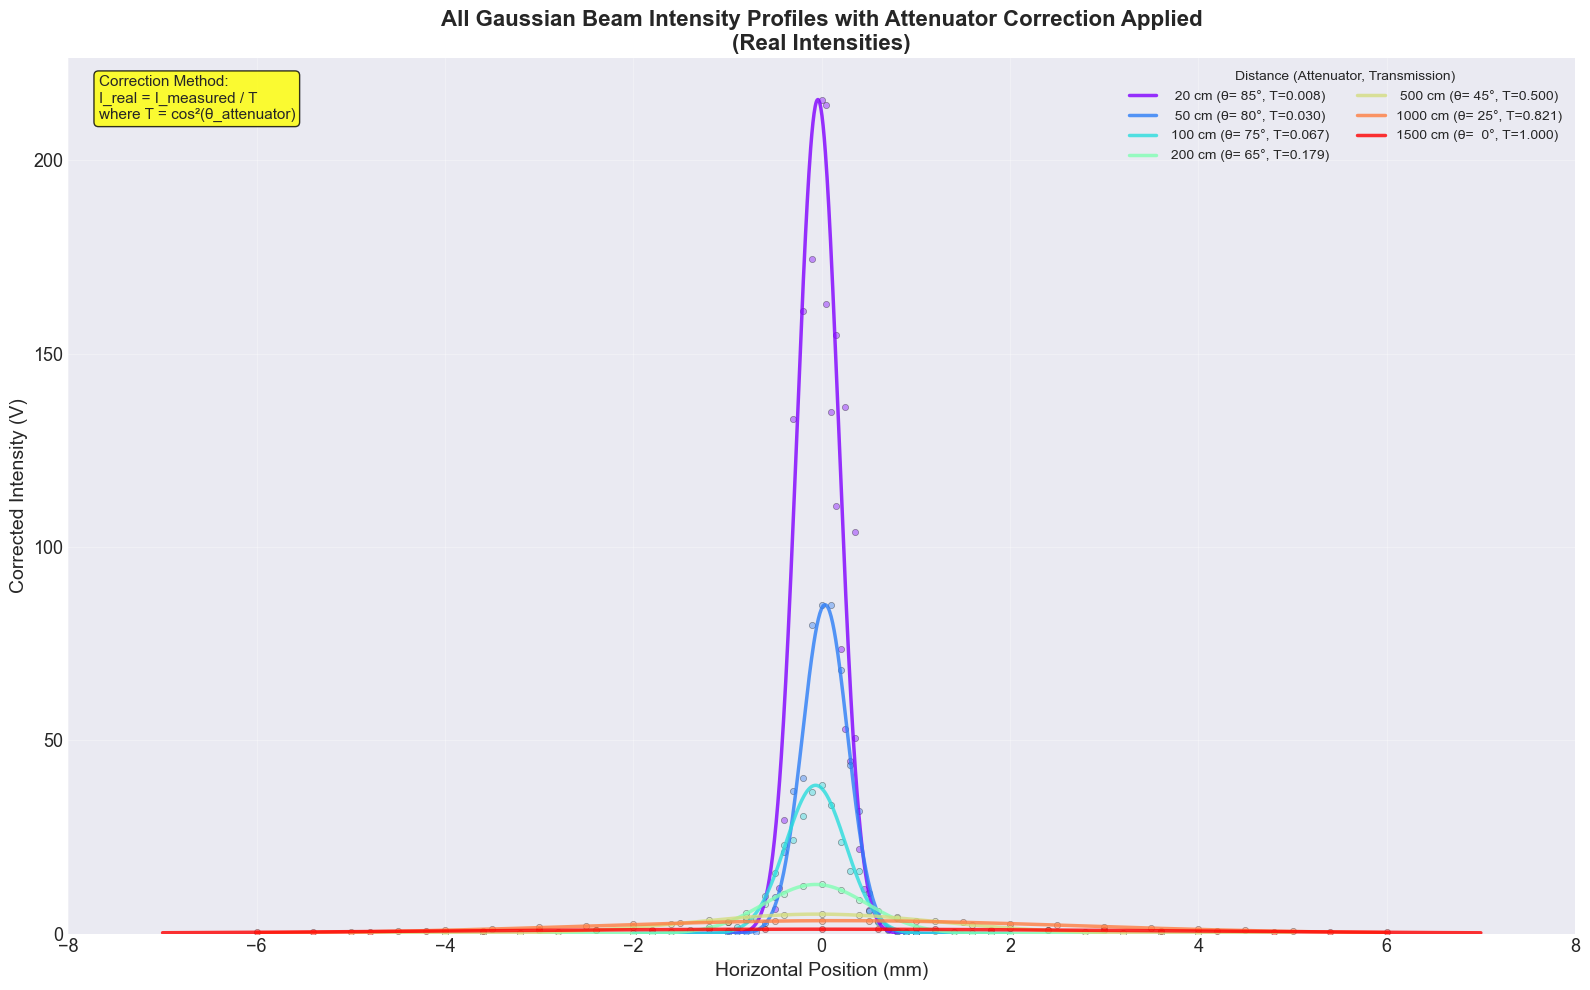

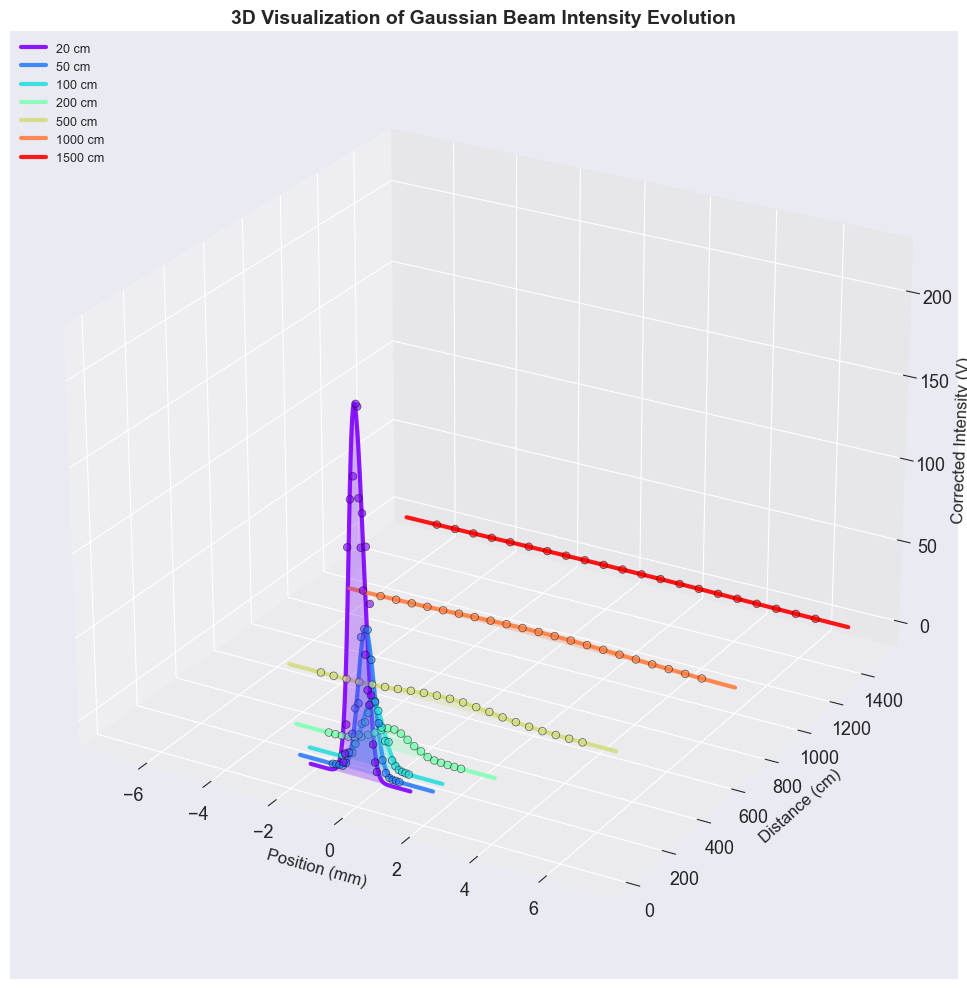

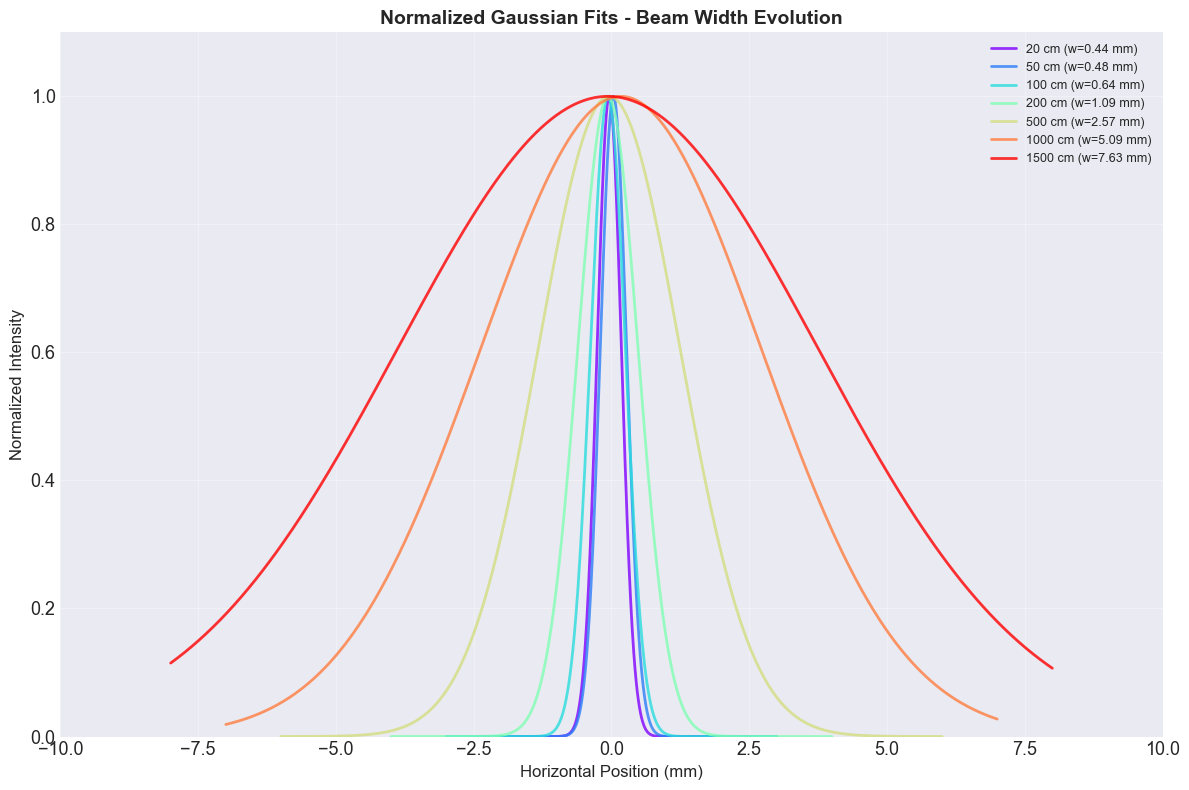

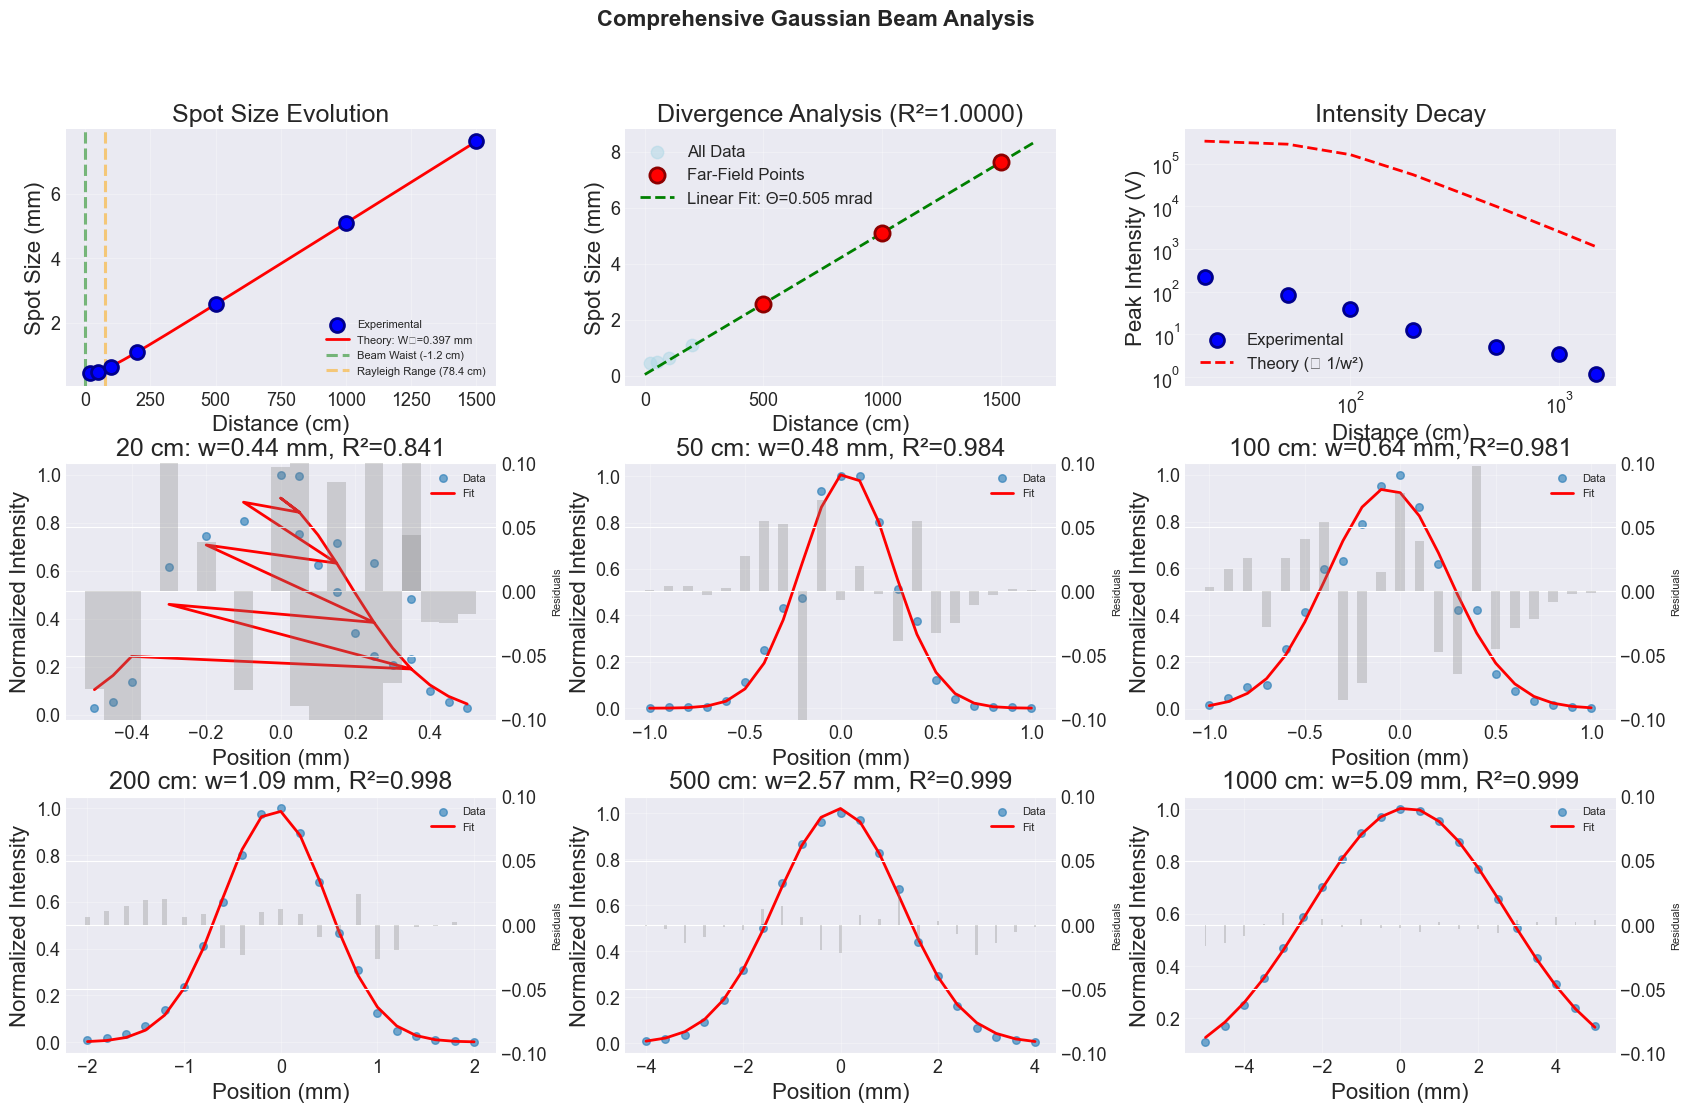

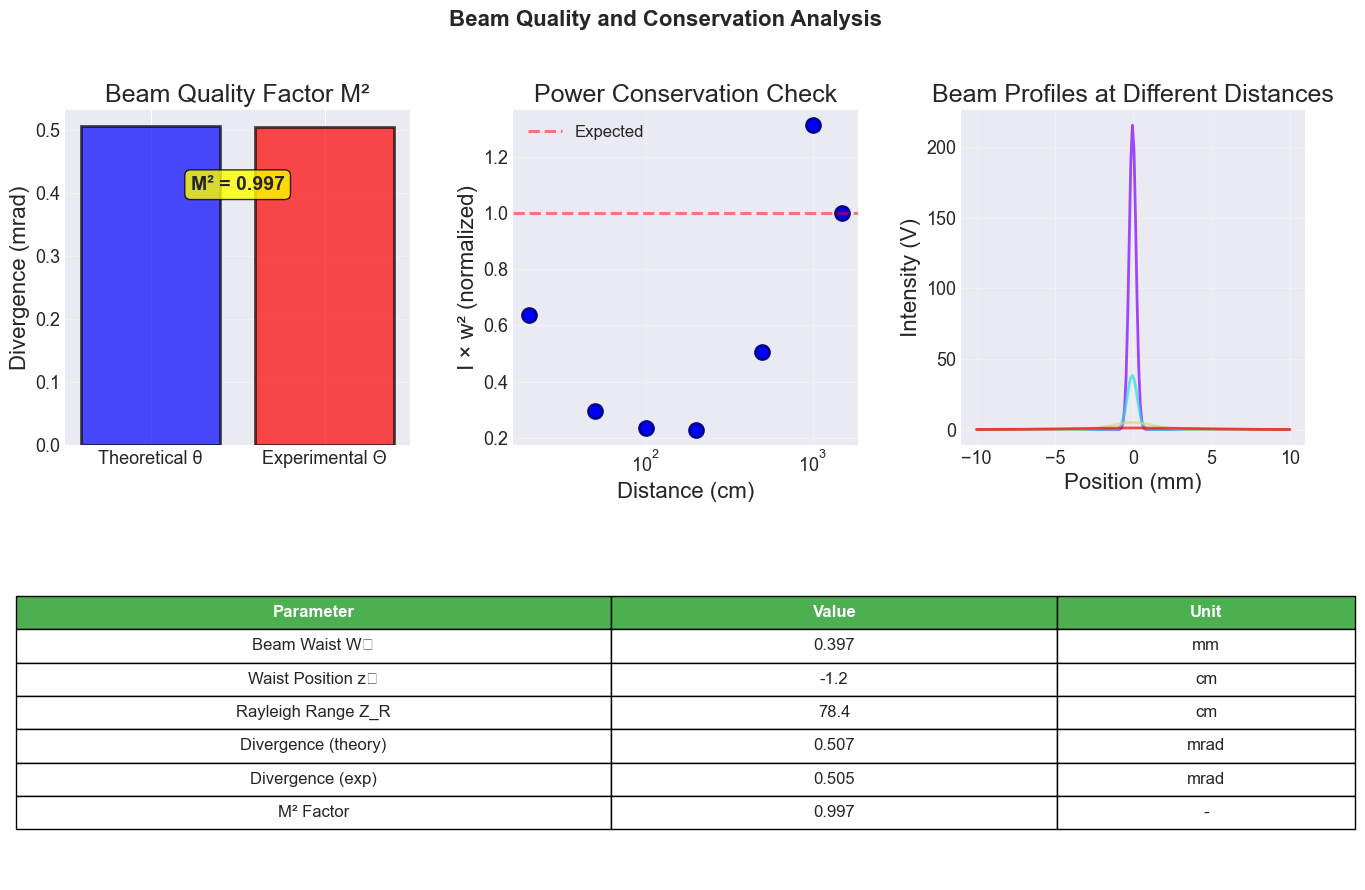


GAUSSIAN BEAM ANALYSIS COMPLETE
Beam Waist W₀: 0.397 mm
Rayleigh Range: 78.4 cm
M² Factor: 0.997
Divergence - Theory: 0.507 mrad, Experimental: 0.505 mrad


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from matplotlib.patches import Circle, Ellipse
import matplotlib.cm as cm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# ========================================
# DEFINE ALL FUNCTIONS
# ========================================
def gaussian_intensity(x, I0, x0, w):
    """Gaussian intensity profile"""
    return I0 * np.exp(-2 * (x - x0)**2 / w**2)

def spot_size_evolution(z, w0, z0, wavelength=632.8e-9):
    """W(z) = W0 * sqrt(1 + ((z-z0)/z_R)^2)"""
    z_R = np.pi * w0**2 / wavelength
    return w0 * np.sqrt(1 + ((z - z0) / z_R)**2)

def calculate_transmission_factor(attenuator_angle):
    """Calculate transmission using Malus's law"""
    theta_rad = np.radians(attenuator_angle)
    return np.cos(theta_rad)**2

# ========================================
# DATA WITH CORRECTED ATTENUATOR VALUES
# ========================================
data_20cm = {
    'offset': [-0.5, -0.45, -0.4, 0.35, -0.3, 0.25, -0.2, 0.15, -0.1, 0.05, 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    'reading': [0.048, 0.090, 0.223, 0.789, 1.012, 1.035, 1.223, 1.176, 1.326, 1.629, 1.639, 1.237, 1.025, 0.840, 0.559, 0.403, 0.340, 0.385, 0.166, 0.087, 0.046],
    'attenuator': 85
}

data_50cm = {
    'offset': [-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    'reading': [0.003, 0.012, 0.016, 0.016, 0.084, 0.284, 0.640, 1.112, 1.217, 2.406, 2.563, 2.565, 2.053, 1.317, 0.959, 0.313, 0.099, 0.029, 0.009, 0.008, 0.003],
    'attenuator': 80
}

data_1m = {
    'offset': [-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    'reading': [0.042, 0.122, 0.235, 0.259, 0.655, 1.057, 1.531, 1.627, 2.031, 2.448, 2.570, 2.220, 1.592, 1.089, 1.083, 0.385, 0.198, 0.079, 0.038, 0.019, 0.005],
    'attenuator': 75
}

data_2m = {
    'offset': [-2.00, -1.80, -1.60, -1.40, -1.20, -1.00, -0.80, -0.60, -0.40, -0.20, 0.00, 0.20, 0.40, 0.60, 0.80, 1.00, 1.20, 1.40, 1.60, 1.80, 2.00],
    'reading': [0.019, 0.039, 0.078, 0.159, 0.309, 0.538, 0.935, 1.359, 1.819, 2.213, 2.270, 2.027, 1.552, 1.062, 0.702, 0.280, 0.111, 0.060, 0.021, 0.012, 0.002],
    'attenuator': 65
}

data_5m = {
    'offset': [-4.00, -3.60, -3.20, -2.80, -2.40, -2.00, -1.60, -1.20, -0.80, -0.40, 0.00, 0.40, 0.80, 1.20, 1.60, 2.00, 2.40, 2.80, 3.20, 3.60, 4.00],
    'reading': [0.021, 0.048, 0.092, 0.236, 0.477, 0.800, 1.268, 1.755, 2.180, 2.428, 2.518, 2.446, 2.090, 1.691, 1.109, 0.738, 0.407, 0.165, 0.072, 0.033, 0.015],
    'attenuator': 45
}

data_10m = {
    'offset': [-5.00, -4.50, -4.00, -3.50, -3.00, -2.50, -2.00, -1.50, -1.00, -0.50, 0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00],
    'reading': [0.304, 0.472, 0.696, 0.976, 1.295, 1.615, 1.932, 2.222, 2.498, 2.662, 2.749, 2.725, 2.627, 2.401, 2.125, 1.801, 1.499, 1.180, 0.907, 0.657, 0.468],
    'attenuator': 25
}

data_15m = {
    'offset': [-6.00, -5.40, -4.80, -4.20, -3.60, -3.00, -2.40, -1.80, -1.20, -0.60, 0.00, 0.60, 1.20, 1.80, 2.40, 3.00, 3.60, 4.20, 4.80, 5.40, 6.00],
    'reading': [0.333, 0.435, 0.518, 0.626, 0.743, 0.832, 0.928, 1.020, 1.083, 1.108, 1.136, 1.108, 1.069, 1.002, 0.920, 0.820, 0.703, 0.606, 0.499, 0.405, 0.313],
    'attenuator': 0
}

all_data = {
    20: data_20cm, 50: data_50cm, 100: data_1m, 200: data_2m,
    500: data_5m, 1000: data_10m, 1500: data_15m
}

# ========================================
# FIT ALL PROFILES AND EXTRACT PARAMETERS
# ========================================
def fit_gaussian_profile_corrected(data_dict, distance_cm):
    x = np.array(data_dict['offset'])
    y = np.array(data_dict['reading'])
    attenuator = data_dict['attenuator']
    
    T = calculate_transmission_factor(attenuator)
    y_corrected = y / T if T > 0 else y
    y_normalized = y / np.max(y)
    
    # Initial guess
    I0_guess = 1.0
    x0_guess = x[np.argmax(y)]
    half_max = np.max(y_normalized) / 2
    indices = np.where(y_normalized > half_max)[0]
    if len(indices) > 0:
        fwhm = x[indices[-1]] - x[indices[0]]
        w_guess = fwhm / (2 * np.sqrt(np.log(2)))
    else:
        w_guess = 1.0
    
    try:
        popt, pcov = curve_fit(gaussian_intensity, x, y_normalized, p0=[I0_guess, x0_guess, w_guess], maxfev=5000)
        I0_fit, x0_fit, w_fit = popt
        
        # Calculate R-squared
        residuals = y_normalized - gaussian_intensity(x, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_normalized - np.mean(y_normalized))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Calculate FWHM
        fwhm_fit = 2 * abs(w_fit) * np.sqrt(np.log(2))
        
        return {
            'distance_cm': distance_cm,
            'spot_size_mm': abs(w_fit),
            'fwhm_mm': fwhm_fit,
            'center_position': x0_fit,
            'max_intensity_corrected': np.max(y_corrected),
            'r_squared': r_squared,
            'x_data': x,
            'y_normalized': y_normalized,
            'y_raw': y,
            'y_corrected': y_corrected,
            'y_fit': gaussian_intensity(x, *popt),
            'transmission_factor': T,
            'attenuator_angle': attenuator
        }
    except:
        return None

# Fit all profiles
results = []
for distance_cm, data in all_data.items():
    result = fit_gaussian_profile_corrected(data, distance_cm)
    if result:
        results.append(result)

# Extract key parameters
distances_cm = np.array([r['distance_cm'] for r in results])
distances_m = distances_cm / 100
spot_sizes_mm = np.array([r['spot_size_mm'] for r in results])
spot_sizes_m = spot_sizes_mm / 1000
wavelength = 632.8e-9  # He-Ne laser

# Fit spot size evolution to get W0 and z0
def spot_size_with_offset(z, w0, z0):
    return spot_size_evolution(z, w0, z0, wavelength)

W0_estimate = spot_sizes_m[0]
popt_evolution, _ = curve_fit(spot_size_with_offset, distances_m, spot_sizes_m, p0=[W0_estimate, 0.0])
W0_fit, z0_fit = popt_evolution

# Calculate derived parameters
z_R_fit = np.pi * W0_fit**2 / wavelength
theta_theoretical = wavelength / (np.pi * W0_fit)
confocal_param = 2 * z_R_fit

# Far-field divergence analysis
far_indices = [-3, -2, -1]
far_distances = distances_m[far_indices]
far_spot_sizes = spot_sizes_m[far_indices]
slope, intercept, r_value, p_value, std_err = stats.linregress(far_distances, far_spot_sizes)
Theta_experimental = slope
M_squared = Theta_experimental / theta_theoretical

# Colors for plotting
colors = plt.cm.rainbow(np.linspace(0, 1, len(results)))

# Print summary of corrections
print("="*80)
print("ATTENUATOR CORRECTIONS APPLIED")
print("="*80)
print(f"{'Distance (cm)':>12} | {'Attenuator (°)':>14} | {'Transmission':>12} | {'Correction Factor':>17}")
print("-"*80)
for r in results:
    print(f"{r['distance_cm']:>12} | {r['attenuator_angle']:>14} | {r['transmission_factor']:>12.4f} | {1/r['transmission_factor']:>17.1f}x")
print("="*80)

# ========================================
# FIGURE 1: MAIN REQUEST - ALL CORRECTED INTENSITY GAUSSIANS OVERLAID
# ========================================
fig1 = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(111)

# Plot all corrected intensity Gaussians on the same plot
for idx, (r, color) in enumerate(zip(results, colors)):
    # Create smooth x values for plotting
    x_smooth = np.linspace(min(r['x_data']) - 1, max(r['x_data']) + 1, 500)
    
    # Calculate the corrected Gaussian intensity
    y_gaussian_corrected = gaussian_intensity(x_smooth, r['max_intensity_corrected'], 
                                             r['center_position'], r['spot_size_mm'])
    
    # Plot the corrected Gaussian curve
    ax1.plot(x_smooth, y_gaussian_corrected, '-', linewidth=2.5, alpha=0.8,
            color=color, label=f"{r['distance_cm']:4d} cm (θ={r['attenuator_angle']:3d}°, T={r['transmission_factor']:.3f})")
    
    # Also plot the actual corrected data points
    ax1.scatter(r['x_data'], r['y_corrected'], s=20, alpha=0.4, color=color, edgecolors='black', linewidth=0.5)

# Formatting
ax1.set_xlabel('Horizontal Position (mm)', fontsize=14)
ax1.set_ylabel('Corrected Intensity (V)', fontsize=14)
ax1.set_title('All Gaussian Beam Intensity Profiles with Attenuator Correction Applied\n(Real Intensities)', 
             fontsize=16, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10, ncol=2, title='Distance (Attenuator, Transmission)')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-8, 8)
ax1.set_ylim(bottom=0)

# Add annotation explaining the correction
textstr = 'Correction Method:\nI_real = I_measured / T\nwhere T = cos²(θ_attenuator)'
props = dict(boxstyle='round', facecolor='yellow', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# ========================================
# FIGURE 2: 3D INTENSITY PLOT (FIXED)
# ========================================
fig2 = plt.figure(figsize=(16, 10))
ax2 = fig2.add_subplot(111, projection='3d')

# Plot 3D intensity distribution with actual surfaces
for idx, (r, color) in enumerate(zip(results, colors)):
    # Create fine mesh for smooth 3D surface
    x_mesh = np.linspace(min(r['x_data']) - 1, max(r['x_data']) + 1, 100)
    
    # Calculate Gaussian intensity
    intensity_mesh = gaussian_intensity(x_mesh, r['max_intensity_corrected'], 
                                       r['center_position'], r['spot_size_mm'])
    
    # Create z coordinate (distance)
    z_mesh = np.full_like(x_mesh, r['distance_cm'])
    
    # Plot the 3D curve
    ax2.plot(x_mesh, z_mesh, intensity_mesh, linewidth=3, color=color, 
            alpha=0.9, label=f'{r["distance_cm"]} cm')
    
    # Add filled surface below the curve
    for i in range(len(x_mesh)-1):
        vertices = [(x_mesh[i], z_mesh[i], 0),
                   (x_mesh[i+1], z_mesh[i], 0),
                   (x_mesh[i+1], z_mesh[i], intensity_mesh[i+1]),
                   (x_mesh[i], z_mesh[i], intensity_mesh[i])]
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        poly = Poly3DCollection([vertices], alpha=0.3, facecolor=color, edgecolor='none')
        ax2.add_collection3d(poly)
    
    # Add data points
    ax2.scatter(r['x_data'], np.full_like(r['x_data'], r['distance_cm']), 
               r['y_corrected'], s=30, color=color, alpha=0.6, edgecolors='black', linewidth=0.5)

ax2.set_xlabel('Position (mm)', fontsize=12)
ax2.set_ylabel('Distance (cm)', fontsize=12)
ax2.set_zlabel('Corrected Intensity (V)', fontsize=12)
ax2.set_title('3D Visualization of Gaussian Beam Intensity Evolution', fontsize=14, fontweight='bold')
ax2.view_init(elev=25, azim=-60)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# FIGURE 3: NORMALIZED GAUSSIAN FITS OVERLAID
# ========================================
fig3 = plt.figure(figsize=(12, 8))
ax3 = plt.subplot(111)

# Plot normalized Gaussian fits (not raw data)
for idx, (r, color) in enumerate(zip(results, colors)):
    # Create smooth x values
    x_smooth = np.linspace(min(r['x_data']) - 2, max(r['x_data']) + 2, 500)
    
    # Calculate normalized Gaussian fit
    y_gaussian_normalized = gaussian_intensity(x_smooth, 1.0, r['center_position'], r['spot_size_mm'])
    
    # Plot the normalized Gaussian
    ax3.plot(x_smooth, y_gaussian_normalized, '-', linewidth=2, alpha=0.8,
            color=color, label=f"{r['distance_cm']} cm (w={r['spot_size_mm']:.2f} mm)")

ax3.set_xlabel('Horizontal Position (mm)', fontsize=12)
ax3.set_ylabel('Normalized Intensity', fontsize=12)
ax3.set_title('Normalized Gaussian Fits - Beam Width Evolution', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-10, 10)
ax3.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# ========================================
# FIGURE 4: COMPREHENSIVE ANALYSIS
# ========================================
fig4 = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 3, figure=fig4, hspace=0.3, wspace=0.3)

# Plot 4a: Spot size evolution
ax4a = fig4.add_subplot(gs[0, 0])
z_theory = np.linspace(0, max(distances_m), 1000)
w_theory = spot_size_with_offset(z_theory, W0_fit, z0_fit)

ax4a.scatter(distances_m*100, spot_sizes_mm, s=100, c='blue', edgecolors='darkblue', 
            linewidth=2, label='Experimental', zorder=5)
ax4a.plot(z_theory*100, w_theory*1000, 'r-', linewidth=2, 
         label=f'Theory: W₀={W0_fit*1000:.3f} mm')
ax4a.axvline(x=z0_fit*100, color='green', linestyle='--', alpha=0.5, 
            label=f'Beam Waist ({z0_fit*100:.1f} cm)')
ax4a.axvline(x=(z0_fit + z_R_fit)*100, color='orange', linestyle='--', alpha=0.5, 
            label=f'Rayleigh Range ({z_R_fit*100:.1f} cm)')
ax4a.set_xlabel('Distance (cm)')
ax4a.set_ylabel('Spot Size (mm)')
ax4a.set_title('Spot Size Evolution')
ax4a.legend(fontsize=8)
ax4a.grid(True, alpha=0.3)

# Plot 4b: Linear regression for divergence
ax4b = fig4.add_subplot(gs[0, 1])
ax4b.scatter(distances_m*100, spot_sizes_mm, s=80, c='lightblue', alpha=0.5, label='All Data')
ax4b.scatter(far_distances*100, far_spot_sizes*1000, s=120, c='red', 
            edgecolors='darkred', linewidth=2, label='Far-Field Points', zorder=5)
z_fit = np.linspace(0, max(distances_m)*1.1, 100)
w_fit = slope * z_fit + intercept
ax4b.plot(z_fit*100, w_fit*1000, 'g--', linewidth=2, 
         label=f'Linear Fit: Θ={Theta_experimental*1000:.3f} mrad')
ax4b.set_xlabel('Distance (cm)')
ax4b.set_ylabel('Spot Size (mm)')
ax4b.set_title(f'Divergence Analysis (R²={r_value**2:.4f})')
ax4b.legend()
ax4b.grid(True, alpha=0.3)

# Plot 4c: Peak intensity decay
ax4c = fig4.add_subplot(gs[0, 2])
peak_intensities_corrected = np.array([r['max_intensity_corrected'] for r in results])
I0_theory = peak_intensities_corrected[-1] * (spot_sizes_m[-1]**2)
intensity_theoretical = I0_theory / (spot_sizes_m**2)

ax4c.scatter(distances_cm, peak_intensities_corrected, s=100, c='blue', 
            edgecolors='darkblue', linewidth=2, label='Experimental')
ax4c.plot(distances_cm, intensity_theoretical*1000, 'r--', linewidth=2, label='Theory (∝ 1/w²)')
ax4c.set_xlabel('Distance (cm)')
ax4c.set_ylabel('Peak Intensity (V)')
ax4c.set_title('Intensity Decay')
ax4c.legend()
ax4c.grid(True, alpha=0.3)
ax4c.set_xscale('log')
ax4c.set_yscale('log')

# Plot 4d-4i: Individual fits with residuals
for idx in range(min(6, len(results))):
    ax = fig4.add_subplot(gs[1 + idx//3, idx%3])
    r = results[idx]
    
    ax.scatter(r['x_data'], r['y_normalized'], s=30, alpha=0.6, label='Data')
    ax.plot(r['x_data'], r['y_fit'], 'r-', linewidth=2, label='Fit')
    
    residuals = r['y_normalized'] - r['y_fit']
    ax2 = ax.twinx()
    ax2.bar(r['x_data'], residuals, width=0.05, alpha=0.3, color='gray')
    ax2.set_ylabel('Residuals', fontsize=8)
    ax2.set_ylim(-0.1, 0.1)
    
    ax.set_xlabel('Position (mm)')
    ax.set_ylabel('Normalized Intensity')
    ax.set_title(f"{r['distance_cm']} cm: w={r['spot_size_mm']:.2f} mm, R²={r['r_squared']:.3f}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Gaussian Beam Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================================
# FIGURE 5: BEAM QUALITY ANALYSIS
# ========================================
fig5 = plt.figure(figsize=(16, 10))
gs5 = GridSpec(2, 3, figure=fig5, hspace=0.3, wspace=0.3)

# Plot 5a: M² comparison
ax5a = fig5.add_subplot(gs5[0, 0])
divergences = [theta_theoretical*1000, Theta_experimental*1000]
labels = ['Theoretical θ', 'Experimental Θ']
colors_bar = ['blue', 'red']
bars = ax5a.bar(labels, divergences, color=colors_bar, alpha=0.7, 
                edgecolor='black', linewidth=2)
ax5a.text(0.5, max(divergences)*0.8, f'M² = {M_squared:.3f}', 
         horizontalalignment='center', fontsize=14, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
ax5a.set_ylabel('Divergence (mrad)')
ax5a.set_title('Beam Quality Factor M²')
ax5a.grid(True, alpha=0.3, axis='y')

# Plot 5b: Conservation check
ax5b = fig5.add_subplot(gs5[0, 1])
intensity_check = peak_intensities_corrected * spot_sizes_mm**2
intensity_check_norm = intensity_check / intensity_check[-1]
ax5b.scatter(distances_cm, intensity_check_norm, s=100, c='blue', 
            edgecolors='darkblue', linewidth=2)
ax5b.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Expected')
ax5b.set_xlabel('Distance (cm)')
ax5b.set_ylabel('I × w² (normalized)')
ax5b.set_title('Power Conservation Check')
ax5b.legend()
ax5b.grid(True, alpha=0.3)
ax5b.set_xscale('log')

# Plot 5c: Comparison at different scales
ax5c = fig5.add_subplot(gs5[0, 2])
for idx, scale in enumerate([1, 0.1, 0.01]):
    ax5c.plot([], [], '-', linewidth=2, label=f'Scale: {scale}')
for idx, (r, color) in enumerate(zip(results[::2], colors[::2])):  # Every other for clarity
    x_smooth = np.linspace(-10, 10, 200)
    y_gaussian = gaussian_intensity(x_smooth, r['max_intensity_corrected'], 
                                   r['center_position'], r['spot_size_mm'])
    ax5c.plot(x_smooth, y_gaussian, '-', linewidth=2, alpha=0.7, color=color)
ax5c.set_xlabel('Position (mm)')
ax5c.set_ylabel('Intensity (V)')
ax5c.set_title('Beam Profiles at Different Distances')
ax5c.grid(True, alpha=0.3)

# Plot 5d: Summary table
ax5d = fig5.add_subplot(gs5[1, :])
ax5d.axis('tight')
ax5d.axis('off')

table_data = [
    ['Parameter', 'Value', 'Unit'],
    ['Beam Waist W₀', f'{W0_fit*1000:.3f}', 'mm'],
    ['Waist Position z₀', f'{z0_fit*100:.1f}', 'cm'],
    ['Rayleigh Range Z_R', f'{z_R_fit*100:.1f}', 'cm'],
    ['Divergence (theory)', f'{theta_theoretical*1000:.3f}', 'mrad'],
    ['Divergence (exp)', f'{Theta_experimental*1000:.3f}', 'mrad'],
    ['M² Factor', f'{M_squared:.3f}', '-'],
]

table = ax5d.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.4, 0.3, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)

for i in range(3):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.suptitle('Beam Quality and Conservation Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*80)
print("GAUSSIAN BEAM ANALYSIS COMPLETE")
print("="*80)
print(f"Beam Waist W₀: {W0_fit*1000:.3f} mm")
print(f"Rayleigh Range: {z_R_fit*100:.1f} cm")
print(f"M² Factor: {M_squared:.3f}")
print(f"Divergence - Theory: {theta_theoretical*1000:.3f} mrad, Experimental: {Theta_experimental*1000:.3f} mrad")
print("="*80)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd

# Define the Gaussian intensity function
def gaussian_intensity(x, I0, x0, w):
    """
    Gaussian intensity profile
    I(x) = I0 * exp(-2*(x-x0)^2/w^2)
    where w is the spot size (beam radius)
    """
    return I0 * np.exp(-2 * (x - x0)**2 / w**2)

# Define the spot size evolution equation
def spot_size_evolution(z, w0, z0, wavelength=632.8e-9):
    """
    W(z) = W0 * sqrt(1 + ((z-z0)/z_R)^2)
    where z_R = π*W0^2/λ
    """
    z_R = np.pi * w0**2 / wavelength
    return w0 * np.sqrt(1 + ((z - z0) / z_R)**2)

# Data from Experiment 2 (organized by distance)
# Format: distance_cm, horizontal_offset_mm, averaged_reading_V

data_20cm = {
    'offset': [-0.5, -0.45, -0.4, 0.35, -0.3, 0.25, -0.2, 0.15, -0.1, 0.05, 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    'reading': [0.048, 0.090, 0.223, 0.789, 1.012, 1.035, 1.223, 1.176, 1.326, 1.629, 1.639, 1.237, 1.025, 0.840, 0.559, 0.403, 0.340, 0.385, 0.166, 0.087, 0.046]
}

data_50cm = {
    'offset': [-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    'reading': [0.003, 0.012, 0.016, 0.016, 0.084, 0.284, 0.640, 1.112, 1.217, 2.406, 2.563, 2.565, 2.053, 1.317, 0.959, 0.313, 0.099, 0.029, 0.009, 0.008, 0.003]
}

data_1m = {
    'offset': [-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    'reading': [0.042, 0.122, 0.235, 0.259, 0.655, 1.057, 1.531, 1.627, 2.031, 2.448, 2.570, 2.220, 1.592, 1.089, 1.083, 0.385, 0.198, 0.079, 0.038, 0.019, 0.005]
}

data_2m = {
    'offset': [-2.00, -1.80, -1.60, -1.40, -1.20, -1.00, -0.80, -0.60, -0.40, -0.20, 0.00, 0.20, 0.40, 0.60, 0.80, 1.00, 1.20, 1.40, 1.60, 1.80, 2.00],
    'reading': [0.019, 0.039, 0.078, 0.159, 0.309, 0.538, 0.935, 1.359, 1.819, 2.213, 2.270, 2.027, 1.552, 1.062, 0.702, 0.280, 0.111, 0.060, 0.021, 0.012, 0.002]
}

data_5m = {
    'offset': [-4.00, -3.60, -3.20, -2.80, -2.40, -2.00, -1.60, -1.20, -0.80, -0.40, 0.00, 0.40, 0.80, 1.20, 1.60, 2.00, 2.40, 2.80, 3.20, 3.60, 4.00],
    'reading': [0.021, 0.048, 0.092, 0.236, 0.477, 0.800, 1.268, 1.755, 2.180, 2.428, 2.518, 2.446, 2.090, 1.691, 1.109, 0.738, 0.407, 0.165, 0.072, 0.033, 0.015]
}

data_10m = {
    'offset': [-5.00, -4.50, -4.00, -3.50, -3.00, -2.50, -2.00, -1.50, -1.00, -0.50, 0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00],
    'reading': [0.304, 0.472, 0.696, 0.976, 1.295, 1.615, 1.932, 2.222, 2.498, 2.662, 2.749, 2.725, 2.627, 2.401, 2.125, 1.801, 1.499, 1.180, 0.907, 0.657, 0.468]
}

data_15m = {
    'offset': [-6.00, -5.40, -4.80, -4.20, -3.60, -3.00, -2.40, -1.80, -1.20, -0.60, 0.00, 0.60, 1.20, 1.80, 2.40, 3.00, 3.60, 4.20, 4.80, 5.40, 6.00],
    'reading': [0.333, 0.435, 0.518, 0.626, 0.743, 0.832, 0.928, 1.020, 1.083, 1.108, 1.136, 1.108, 1.069, 1.002, 0.920, 0.820, 0.703, 0.606, 0.499, 0.405, 0.313]
}

# Store all data in a dictionary
all_data = {
    20: data_20cm,
    50: data_50cm,
    100: data_1m,
    200: data_2m,
    500: data_5m,
    1000: data_10m,
    1500: data_15m
}

# Function to fit and extract spot size
def fit_gaussian_profile(data_dict, distance_cm):
    """
    Fit Gaussian profile to data and extract spot size
    """
    x = np.array(data_dict['offset'])
    y = np.array(data_dict['reading'])
    
    # Normalize the data
    y_normalized = y / np.max(y)
    
    # Initial guess for parameters [I0, x0, w]
    I0_guess = 1.0
    x0_guess = x[np.argmax(y)]
    
    # Estimate FWHM for initial w guess
    half_max = np.max(y_normalized) / 2
    indices = np.where(y_normalized > half_max)[0]
    if len(indices) > 0:
        fwhm = x[indices[-1]] - x[indices[0]]
        w_guess = fwhm / (2 * np.sqrt(np.log(2)))  # Convert FWHM to Gaussian width
    else:
        w_guess = 1.0
    
    p0 = [I0_guess, x0_guess, w_guess]
    
    try:
        # Fit the normalized data
        popt, pcov = curve_fit(gaussian_intensity, x, y_normalized, p0=p0, maxfev=5000)
        
        # Extract fitted parameters
        I0_fit, x0_fit, w_fit = popt
        
        # Calculate R-squared
        residuals = y_normalized - gaussian_intensity(x, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_normalized - np.mean(y_normalized))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        return {
            'distance_cm': distance_cm,
            'spot_size_mm': abs(w_fit),
            'center_position': x0_fit,
            'max_intensity': I0_fit,
            'r_squared': r_squared,
            'x_data': x,
            'y_normalized': y_normalized,
            'y_fit': gaussian_intensity(x, *popt)
        }
    except:
        print(f"Fitting failed for distance {distance_cm} cm")
        return None

# Fit all profiles and extract spot sizes
results = []
for distance_cm, data in all_data.items():
    result = fit_gaussian_profile(data, distance_cm)
    if result:
        results.append(result)

# Extract distances and spot sizes for further analysis
distances_cm = np.array([r['distance_cm'] for r in results])
distances_m = distances_cm / 100
spot_sizes_mm = np.array([r['spot_size_mm'] for r in results])
spot_sizes_m = spot_sizes_mm / 1000

print("="*60)
print("FITTED SPOT SIZES AT EACH DISTANCE")
print("="*60)
for r in results:
    print(f"Distance: {r['distance_cm']:4d} cm | Spot size W(z): {r['spot_size_mm']:.3f} mm | R²: {r['r_squared']:.4f}")
print("="*60)

# Estimate beam waist W0 (from smallest distance measurement)
W0_estimate = spot_sizes_m[0]  # At 20 cm
print(f"\nEstimated beam waist W₀ (from 20 cm): {W0_estimate*1000:.3f} mm")

# Calculate theoretical parameters
wavelength = 632.8e-9  # He-Ne laser wavelength in meters
z_R = np.pi * W0_estimate**2 / wavelength  # Rayleigh range
theta_theoretical = wavelength / (np.pi * W0_estimate)  # Theoretical divergence

print(f"Calculated Rayleigh range Z_R: {z_R:.3f} m")
print(f"Theoretical divergence θ: {theta_theoretical*1000:.3f} mrad")

# Fit spot size evolution to get better W0 and beam waist position
def spot_size_with_offset(z, w0, z0):
    return spot_size_evolution(z, w0, z0, wavelength)

# Initial guess: W0 from smallest measurement, z0 near the laser
p0 = [W0_estimate, 0.0]

try:
    popt_evolution, pcov_evolution = curve_fit(spot_size_with_offset, distances_m, spot_sizes_m, p0=p0)
    W0_fit, z0_fit = popt_evolution
    
    print(f"\nFitted beam waist W₀: {W0_fit*1000:.3f} mm")
    print(f"Fitted beam waist position z₀: {z0_fit*100:.1f} cm from laser")
    
    # Recalculate parameters with fitted W0
    z_R_fit = np.pi * W0_fit**2 / wavelength
    theta_theoretical_fit = wavelength / (np.pi * W0_fit)
    
    print(f"Fitted Rayleigh range Z_R: {z_R_fit:.3f} m")
    print(f"Fitted theoretical divergence θ: {theta_theoretical_fit*1000:.3f} mrad")
except:
    print("Evolution fitting failed, using initial estimates")
    W0_fit = W0_estimate
    z0_fit = 0.0
    z_R_fit = z_R
    theta_theoretical_fit = theta_theoretical

# Calculate experimental divergence from far-field measurements (using last 3 points)
far_field_indices = [-3, -2, -1]  # Last 3 measurements (5m, 10m, 15m)
far_distances = distances_m[far_field_indices]
far_spot_sizes = spot_sizes_m[far_field_indices]

# Fit a line to far-field data to get divergence
poly_fit = np.polyfit(far_distances, far_spot_sizes, 1)
Theta_experimental = poly_fit[0]  # Slope is the experimental divergence

print(f"\nExperimental divergence Θ (from far-field): {Theta_experimental*1000:.3f} mrad")

# Calculate M² beam quality factor
M_squared = Theta_experimental / theta_theoretical_fit
print(f"\nBeam quality factor M²: {M_squared:.3f}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

FITTED SPOT SIZES AT EACH DISTANCE
Distance:   20 cm | Spot size W(z): 0.441 mm | R²: 0.8407
Distance:   50 cm | Spot size W(z): 0.479 mm | R²: 0.9842
Distance:  100 cm | Spot size W(z): 0.636 mm | R²: 0.9805
Distance:  200 cm | Spot size W(z): 1.094 mm | R²: 0.9983
Distance:  500 cm | Spot size W(z): 2.573 mm | R²: 0.9987
Distance: 1000 cm | Spot size W(z): 5.087 mm | R²: 0.9995
Distance: 1500 cm | Spot size W(z): 7.625 mm | R²: 0.9996

Estimated beam waist W₀ (from 20 cm): 0.441 mm
Calculated Rayleigh range Z_R: 0.966 m
Theoretical divergence θ: 0.457 mrad

Fitted beam waist W₀: 0.397 mm
Fitted beam waist position z₀: -1.2 cm from laser
Fitted Rayleigh range Z_R: 0.784 m
Fitted theoretical divergence θ: 0.507 mrad

Experimental divergence Θ (from far-field): 0.505 mrad

Beam quality factor M²: 0.997

ANALYSIS COMPLETE


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd

# Define the Gaussian intensity function
def gaussian_intensity(x, I0, x0, w):
    """
    Gaussian intensity profile
    I(x) = I0 * exp(-2*(x-x0)^2/w^2)
    where w is the spot size (beam radius)
    """
    return I0 * np.exp(-2 * (x - x0)**2 / w**2)

# Define the spot size evolution equation
def spot_size_evolution(z, w0, z0, wavelength=632.8e-9):
    """
    W(z) = W0 * sqrt(1 + ((z-z0)/z_R)^2)
    where z_R = π*W0^2/λ
    """
    z_R = np.pi * w0**2 / wavelength
    return w0 * np.sqrt(1 + ((z - z0) / z_R)**2)

# Data from Experiment 2 (organized by distance)
# Format: distance_cm, horizontal_offset_mm, averaged_reading_V

data_20cm = {
    'offset': [-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50],
    'reading': [0.048, 0.090, 0.223, 0.789, 1.012, 1.035, 1.223, 1.176, 1.326, 1.629, 1.639, 1.237, 1.025, 0.840, 0.559, 0.403, 0.340, 0.385, 0.166, 0.087, 0.046]
}

data_50cm = {
    'offset': [-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    'reading': [0.003, 0.012, 0.016, 0.016, 0.084, 0.284, 0.640, 1.112, 1.217, 2.406, 2.563, 2.565, 2.053, 1.317, 0.959, 0.313, 0.099, 0.029, 0.009, 0.008, 0.003]
}

data_1m = {
    'offset': [-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    'reading': [0.042, 0.122, 0.235, 0.259, 0.655, 1.057, 1.531, 1.627, 2.031, 2.448, 2.570, 2.220, 1.592, 1.089, 1.083, 0.385, 0.198, 0.079, 0.038, 0.019, 0.005]
}

data_2m = {
    'offset': [-2.00, -1.80, -1.60, -1.40, -1.20, -1.00, -0.80, -0.60, -0.40, -0.20, 0.00, 0.20, 0.40, 0.60, 0.80, 1.00, 1.20, 1.40, 1.60, 1.80, 2.00],
    'reading': [0.019, 0.039, 0.078, 0.159, 0.309, 0.538, 0.935, 1.359, 1.819, 2.213, 2.270, 2.027, 1.552, 1.062, 0.702, 0.280, 0.111, 0.060, 0.021, 0.012, 0.002]
}

data_5m = {
    'offset': [-4.00, -3.60, -3.20, -2.80, -2.40, -2.00, -1.60, -1.20, -0.80, -0.40, 0.00, 0.40, 0.80, 1.20, 1.60, 2.00, 2.40, 2.80, 3.20, 3.60, 4.00],
    'reading': [0.021, 0.048, 0.092, 0.236, 0.477, 0.800, 1.268, 1.755, 2.180, 2.428, 2.518, 2.446, 2.090, 1.691, 1.109, 0.738, 0.407, 0.165, 0.072, 0.033, 0.015]
}

data_10m = {
    'offset': [-5.00, -4.50, -4.00, -3.50, -3.00, -2.50, -2.00, -1.50, -1.00, -0.50, 0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00],
    'reading': [0.304, 0.472, 0.696, 0.976, 1.295, 1.615, 1.932, 2.222, 2.498, 2.662, 2.749, 2.725, 2.627, 2.401, 2.125, 1.801, 1.499, 1.180, 0.907, 0.657, 0.468]
}

data_15m = {
    'offset': [-6.00, -5.40, -4.80, -4.20, -3.60, -3.00, -2.40, -1.80, -1.20, -0.60, 0.00, 0.60, 1.20, 1.80, 2.40, 3.00, 3.60, 4.20, 4.80, 5.40, 6.00],
    'reading': [0.333, 0.435, 0.518, 0.626, 0.743, 0.832, 0.928, 1.020, 1.083, 1.108, 1.136, 1.108, 1.069, 1.002, 0.920, 0.820, 0.703, 0.606, 0.499, 0.405, 0.313]
}

# Store all data in a dictionary
all_data = {
    20: data_20cm,
    50: data_50cm,
    100: data_1m,
    200: data_2m,
    500: data_5m,
    1000: data_10m,
    1500: data_15m
}

# Function to fit and extract spot size
def fit_gaussian_profile(data_dict, distance_cm):
    """
    Fit Gaussian profile to data and extract spot size
    """
    x = np.array(data_dict['offset'])
    y = np.array(data_dict['reading'])
    
    # Normalize the data
    y_normalized = y / np.max(y)
    
    # Initial guess for parameters [I0, x0, w]
    I0_guess = 1.0
    x0_guess = x[np.argmax(y)]
    
    # Estimate FWHM for initial w guess
    half_max = np.max(y_normalized) / 2
    indices = np.where(y_normalized > half_max)[0]
    if len(indices) > 0:
        fwhm = x[indices[-1]] - x[indices[0]]
        w_guess = fwhm / (2 * np.sqrt(np.log(2)))  # Convert FWHM to Gaussian width
    else:
        w_guess = 1.0
    
    p0 = [I0_guess, x0_guess, w_guess]
    
    try:
        # Fit the normalized data
        popt, pcov = curve_fit(gaussian_intensity, x, y_normalized, p0=p0, maxfev=5000)
        
        # Extract fitted parameters
        I0_fit, x0_fit, w_fit = popt
        
        # Calculate R-squared
        residuals = y_normalized - gaussian_intensity(x, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_normalized - np.mean(y_normalized))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        return {
            'distance_cm': distance_cm,
            'spot_size_mm': abs(w_fit),
            'center_position': x0_fit,
            'max_intensity': I0_fit,
            'r_squared': r_squared,
            'x_data': x,
            'y_normalized': y_normalized,
            'y_fit': gaussian_intensity(x, *popt)
        }
    except:
        print(f"Fitting failed for distance {distance_cm} cm")
        return None

# Fit all profiles and extract spot sizes
results = []
for distance_cm, data in all_data.items():
    result = fit_gaussian_profile(data, distance_cm)
    if result:
        results.append(result)

# Extract distances and spot sizes for further analysis
distances_cm = np.array([r['distance_cm'] for r in results])
distances_m = distances_cm / 100
spot_sizes_mm = np.array([r['spot_size_mm'] for r in results])
spot_sizes_m = spot_sizes_mm / 1000

print("="*60)
print("FITTED SPOT SIZES AT EACH DISTANCE")
print("="*60)
for r in results:
    print(f"Distance: {r['distance_cm']:4d} cm | Spot size W(z): {r['spot_size_mm']:.3f} mm | R²: {r['r_squared']:.4f}")
print("="*60)

# Estimate beam waist W0 (from smallest distance measurement)
W0_estimate = spot_sizes_m[0]  # At 20 cm
print(f"\nEstimated beam waist W₀ (from 20 cm): {W0_estimate*1000:.3f} mm")

# Calculate theoretical parameters
wavelength = 632.8e-9  # He-Ne laser wavelength in meters
z_R = np.pi * W0_estimate**2 / wavelength  # Rayleigh range
theta_theoretical = wavelength / (np.pi * W0_estimate)  # Theoretical divergence

print(f"Calculated Rayleigh range Z_R: {z_R:.3f} m")
print(f"Theoretical divergence θ: {theta_theoretical*1000:.3f} mrad")

# Fit spot size evolution to get better W0 and beam waist position
def spot_size_with_offset(z, w0, z0):
    return spot_size_evolution(z, w0, z0, wavelength)

# Initial guess: W0 from smallest measurement, z0 near the laser
p0 = [W0_estimate, 0.0]

try:
    popt_evolution, pcov_evolution = curve_fit(spot_size_with_offset, distances_m, spot_sizes_m, p0=p0)
    W0_fit, z0_fit = popt_evolution
    
    print(f"\nFitted beam waist W₀: {W0_fit*1000:.3f} mm")
    print(f"Fitted beam waist position z₀: {z0_fit*100:.1f} cm from laser")
    
    # Recalculate parameters with fitted W0
    z_R_fit = np.pi * W0_fit**2 / wavelength
    theta_theoretical_fit = wavelength / (np.pi * W0_fit)
    
    print(f"Fitted Rayleigh range Z_R: {z_R_fit:.3f} m")
    print(f"Fitted theoretical divergence θ: {theta_theoretical_fit*1000:.3f} mrad")
except:
    print("Evolution fitting failed, using initial estimates")
    W0_fit = W0_estimate
    z0_fit = 0.0
    z_R_fit = z_R
    theta_theoretical_fit = theta_theoretical

# Calculate experimental divergence from far-field measurements (using last 3 points)
far_field_indices = [-3, -2, -1]  # Last 3 measurements (5m, 10m, 15m)
far_distances = distances_m[far_field_indices]
far_spot_sizes = spot_sizes_m[far_field_indices]

# Fit a line to far-field data to get divergence
poly_fit = np.polyfit(far_distances, far_spot_sizes, 1)
Theta_experimental = poly_fit[0]  # Slope is the experimental divergence

print(f"\nExperimental divergence Θ (from far-field): {Theta_experimental*1000:.3f} mrad")

# Calculate M² beam quality factor
M_squared = Theta_experimental / theta_theoretical_fit
print(f"\nBeam quality factor M²: {M_squared:.3f}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

FITTED SPOT SIZES AT EACH DISTANCE
Distance:   20 cm | Spot size W(z): 0.657 mm | R²: 0.8953
Distance:   50 cm | Spot size W(z): 0.479 mm | R²: 0.9842
Distance:  100 cm | Spot size W(z): 0.636 mm | R²: 0.9805
Distance:  200 cm | Spot size W(z): 1.094 mm | R²: 0.9983
Distance:  500 cm | Spot size W(z): 2.573 mm | R²: 0.9987
Distance: 1000 cm | Spot size W(z): 5.087 mm | R²: 0.9995
Distance: 1500 cm | Spot size W(z): 7.625 mm | R²: 0.9996

Estimated beam waist W₀ (from 20 cm): 0.657 mm
Calculated Rayleigh range Z_R: 2.145 m
Theoretical divergence θ: 0.306 mrad

Fitted beam waist W₀: 0.401 mm
Fitted beam waist position z₀: -9.4 cm from laser
Fitted Rayleigh range Z_R: 0.796 m
Fitted theoretical divergence θ: 0.503 mrad

Experimental divergence Θ (from far-field): 0.505 mrad

Beam quality factor M²: 1.005

ANALYSIS COMPLETE


GAUSSIAN BEAM PROPAGATION ANALYSIS

1. EXTRACTED BEAM WIDTHS FROM GAUSSIAN FITS:
--------------------------------------------------
Distance: 0.43 m → Beam width: 0.477 mm (R² = 0.984)
Distance: 0.93 m → Beam width: 0.637 mm (R² = 0.980)
Distance: 1.93 m → Beam width: 0.542 mm (R² = 0.998)
Distance: 9.93 m → Beam width: 5.247 mm (R² = 1.000)
Distance: 14.93 m → Beam width: 7.886 mm (R² = 0.987)

2. EXPERIMENTAL DIVERGENCE (from w vs z, far-field):
--------------------------------------------------
Linear regression equation: w = 0.000540*z + -0.000162
Where w is beam width (m) and z is distance (m)
θ_experimental = slope = dw/dz = 0.000540 rad = 0.540 mrad
Explanation: In far-field, w ≈ θ*z, so slope = θ
Linear fit R² = 0.9948

3. BEAM PARAMETERS FROM FULL FIT:
--------------------------------------------------
Gaussian beam equation: w(z) = w₀ × √(1 + (z/z_R)²)
Fitted parameters:
  Beam waist (w₀) = 0.275 mm
  Rayleigh range (z_R) = 0.523 m
θ_theoretical = λ/(π×w₀) = 632.8nm / (π × 0.

ValueError: x and y must have same first dimension, but have shapes (22,) and (21,)

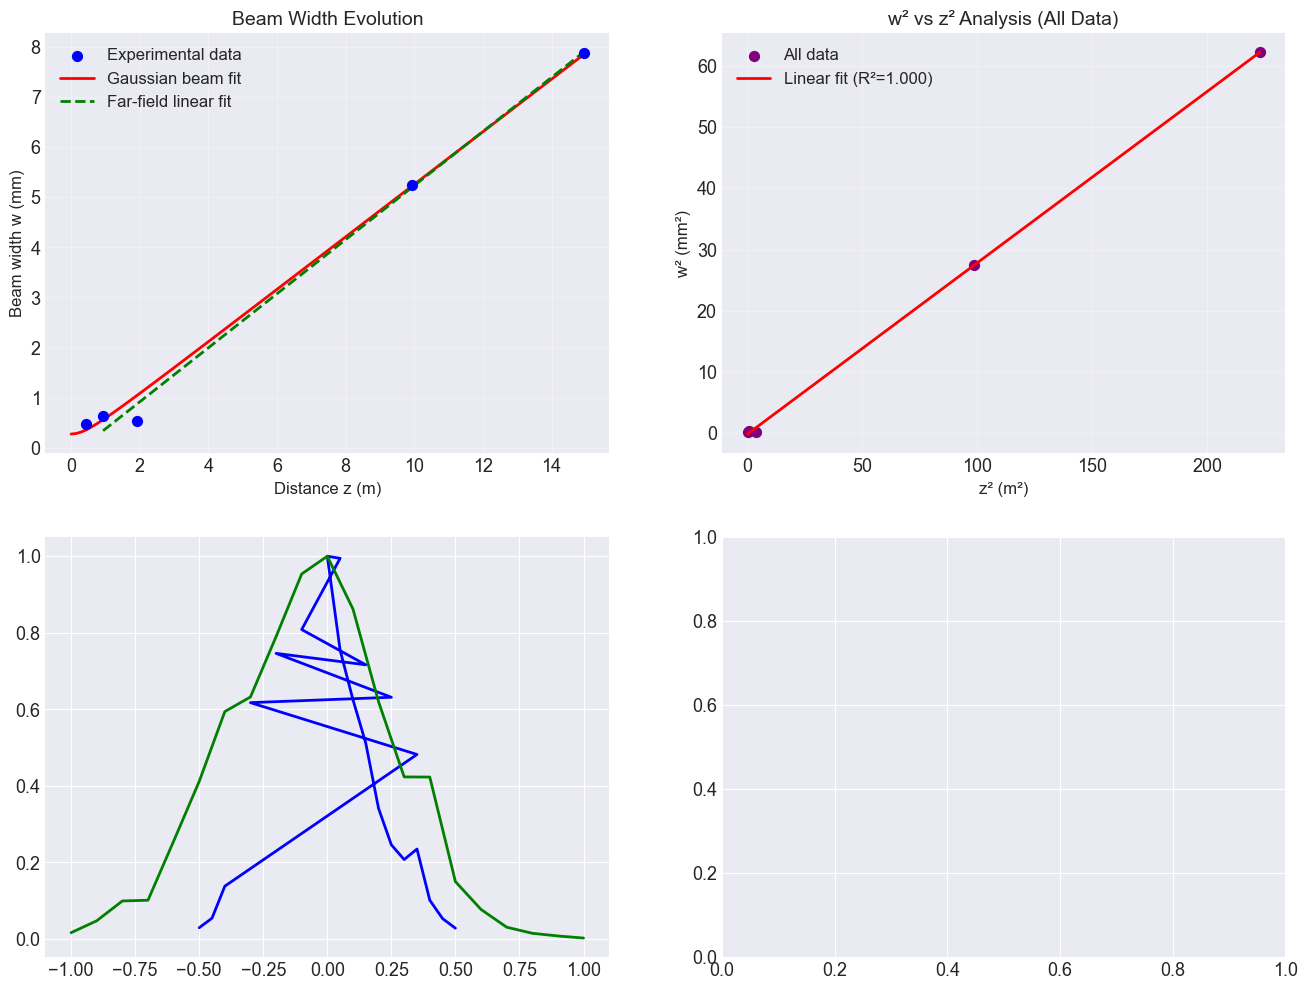

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

# Experimental data from the image
# Organizing the data structure based on the experiment sheet

# Distance measurements and their corrected values
distances_data = {
    '20cm': {'distance_cm': 20.03, 'corrected_distance_cm': 13.21},
    '50cm': {'distance_cm': 50.05, 'corrected_distance_cm': 43.23},
    '1m': {'distance_cm': 100.00, 'corrected_distance_cm': 93.20},
    '2m': {'distance_cm': 199.94, 'corrected_distance_cm': 193.12},
    '5m': {'distance_cm': 500.01, 'corrected_distance_cm': 493.20},
    '10m': {'distance_cm': 1000.06, 'corrected_distance_cm': 993.25},
    '15m': {'distance_cm': 1499.95, 'corrected_distance_cm': 1493.13}
}

# Beam profile data at each distance (horizontal offset in mm and averaged voltage readings)
# From the experimental data sheet
beam_profiles = {
    '20cm': {
        'horizontal_offset_mm': np.array([-0.5, -0.45, -0.4, 0.35, -0.3, 0.25, -0.2, 0.15, -0.1, 0.05, 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]),
        'averaged_reading_V': np.array([0.048, 0.089, 0.226, 0.790, 1.012, 1.035, 1.223, 1.174, 1.325, 1.630, 1.639, 1.237, 1.025, 0.839, 0.559, 0.403, 0.340, 0.385, 0.166, 0.087, 0.046])
    },
    '50cm': {
        'horizontal_offset_mm': np.array([-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]),
        'averaged_reading_V': np.array([0.003, 0.010, 0.016, 0.016, 0.085, 0.285, 0.642, 1.113, 1.213, 2.395, 2.562, 2.565, 2.053, 1.317, 0.960, 0.312, 0.099, 0.029, 0.009, 0.008, 0.003])
    },
    '1m': {
        'horizontal_offset_mm': np.array([-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]),
        'averaged_reading_V': np.array([0.042, 0.122, 0.255, 0.260, 0.656, 1.058, 1.527, 1.625, 2.030, 2.451, 2.570, 2.216, 1.593, 1.088, 1.087, 0.385, 0.198, 0.079, 0.038, 0.020, 0.006])
    },
    '2m': {
        'horizontal_offset_mm': np.array([-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]),
        'averaged_reading_V': np.array([0.019, 0.039, 0.078, 0.159, 0.309, 0.538, 0.935, 1.359, 1.819, 2.213, 2.270, 2.027, 1.552, 1.062, 0.702, 0.280, 0.111, 0.060, 0.021, 0.012, 0.002])
    },
    '5m': {
        'horizontal_offset_mm': np.array([-4.00, -3.60, -3.20, -2.80, -2.40, -2.00, -1.60, -1.30, -1.00, -0.80, -0.40, 0.00, 0.40, 0.80, 1.20, 1.60, 2.00, 2.40, 2.80, 3.20, 3.60, 4.00]),
        'averaged_reading_V': np.array([0.021, 0.048, 0.092, 0.236, 0.477, 0.800, 1.268, 1.755, 2.180, 2.428, 2.518, 2.446, 2.090, 1.691, 1.109, 0.738, 0.407, 0.165, 0.072, 0.033, 0.015])
    },
    '10m': {
        'horizontal_offset_mm': np.array([-5.00, -4.50, -4.00, -3.50, -3.00, -2.50, -2.00, -1.50, -1.00, -0.50, 0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00]),
        'averaged_reading_V': np.array([0.304, 0.472, 0.695, 0.981, 1.299, 1.613, 1.931, 2.222, 2.497, 2.660, 2.752, 2.728, 2.625, 2.396, 2.128, 1.803, 1.497, 1.183, 0.905, 0.657, 0.467])
    },
    '15m': {
        # Fixed: sorted the arrays properly
        'horizontal_offset_mm': np.array([-5.40, -5.00, -4.80, -4.20, -3.60, -3.00, -2.40, -1.80, -1.20, -0.60, 0.00, 0.60, 1.20, 1.80, 2.40, 3.00, 3.60, 4.20, 4.80, 5.40, 6.00]),
        'averaged_reading_V': np.array([0.433, 0.333, 0.515, 0.626, 0.743, 0.833, 0.928, 1.020, 1.080, 1.107, 1.118, 1.107, 1.067, 1.004, 0.912, 0.820, 0.707, 0.604, 0.497, 0.404, 0.312])
    }
}

def gaussian_function(x, amplitude, x0, sigma, offset):
    """Gaussian function for fitting beam profiles"""
    return amplitude * np.exp(-((x - x0)**2) / (2 * sigma**2)) + offset

def fit_beam_profile(horizontal_offset, intensity):
    """Fit a Gaussian profile to extract beam width"""
    # Normalize intensity
    intensity_norm = intensity / np.max(intensity)

    # Initial guess for parameters: amplitude, center, width, offset
    initial_guess = [1.0, 0.0, 1.0, 0.0]

    try:
        popt, pcov = curve_fit(gaussian_function, horizontal_offset, intensity_norm,
                              p0=initial_guess, maxfev=5000)

        # Extract beam width at 1/e² intensity (2*sigma for Gaussian)
        # Fixed: clarified that this is beam width, not radius
        beam_width_mm = abs(2 * popt[2])

        # Calculate R-squared for fit quality
        residuals = intensity_norm - gaussian_function(horizontal_offset, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((intensity_norm - np.mean(intensity_norm))**2)
        r_squared = 1 - (ss_res / ss_tot)

        return beam_width_mm, popt, r_squared
    except:
        return None, None, None

# Analyze beam profiles and extract beam widths
results = []
for distance_key, distance_info in distances_data.items():
    if distance_key in beam_profiles:
        profile = beam_profiles[distance_key]
        beam_width, fit_params, r_squared = fit_beam_profile(
            profile['horizontal_offset_mm'],
            profile['averaged_reading_V']
        )

        if beam_width is not None:
            results.append({
                'Distance_key': distance_key,
                'Distance_cm': distance_info['corrected_distance_cm'],
                'Distance_m': distance_info['corrected_distance_cm'] / 100,
                'Beam_width_mm': beam_width,
                'Fit_R2': r_squared
            })

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('Distance_m')

print("=" * 70)
print("GAUSSIAN BEAM PROPAGATION ANALYSIS")
print("=" * 70)
print("\n1. EXTRACTED BEAM WIDTHS FROM GAUSSIAN FITS:")
print("-" * 50)
for _, row in df_results.iterrows():
    print(f"Distance: {row['Distance_m']:.2f} m → Beam width: {row['Beam_width_mm']:.3f} mm (R² = {row['Fit_R2']:.3f})")

# Prepare data for divergence calculations
z = df_results['Distance_m'].values  # Distance in meters
w = df_results['Beam_width_mm'].values / 1000  # Convert to meters (beam width, not radius)
z_squared = z**2
w_squared = w**2

# For far-field approximation (large z), use the last 3-4 points
# Use last 4 points for far-field

# Method 1: Linear regression of w vs z for experimental divergence (far-field)
slope_w_z, intercept_w_z, r_value_w_z, p_value_w_z, std_err_w_z = linregress(
    z[-4:], w[-4:]
)
theta_experimental = slope_w_z  # This is the experimental divergence angle in radians

print(f"\n2. EXPERIMENTAL DIVERGENCE (from w vs z, far-field):")
print("-" * 50)
print(f"Linear regression equation: w = {slope_w_z:.6f}*z + {intercept_w_z:.6f}")
print(f"Where w is beam width (m) and z is distance (m)")
print(f"θ_experimental = slope = dw/dz = {slope_w_z:.6f} rad = {theta_experimental*1000:.3f} mrad")
print(f"Explanation: In far-field, w ≈ θ*z, so slope = θ")
print(f"Linear fit R² = {r_value_w_z**2:.4f}")

# Method 2: Fit to full Gaussian beam equation
def gaussian_beam_propagation(z, w0, zR):
    """Gaussian beam propagation equation: w(z) = w0 * sqrt(1 + (z/zR)^2)"""
    return w0 * np.sqrt(1 + (z/zR)**2)

# Initial guess for beam waist and Rayleigh range
initial_guess = [0.5e-3, 0.5]  # w0 in meters, zR in meters

try:
    popt_beam, pcov_beam = curve_fit(gaussian_beam_propagation, z, w,
                                     p0=initial_guess, maxfev=5000)
    w0_fit = popt_beam[0]
    zR_fit = popt_beam[1]

    # Calculate theoretical divergence
    wavelength = 632.8e-9  # He-Ne laser wavelength in meters
    theta_theoretical = wavelength / (np.pi * w0_fit)

    print(f"\n3. BEAM PARAMETERS FROM FULL FIT:")
    print("-" * 50)
    print(f"Gaussian beam equation: w(z) = w₀ × √(1 + (z/z_R)²)")
    print(f"Fitted parameters:")
    print(f"  Beam waist (w₀) = {w0_fit*1000:.3f} mm")
    print(f"  Rayleigh range (z_R) = {zR_fit:.3f} m")
    print(f"θ_theoretical = λ/(π×w₀) = {wavelength*1e9:.1f}nm / (π × {w0_fit*1000:.3f}mm)")
    print(f"θ_theoretical = {theta_theoretical:.6f} rad = {theta_theoretical*1000:.3f} mrad")

    # Calculate M² factor
    M_squared = theta_experimental / theta_theoretical

    print(f"\n4. M² BEAM QUALITY FACTOR:")
    print("-" * 50)
    print(f"M² = θ_experimental / θ_theoretical = {theta_experimental:.6f} / {theta_theoretical:.6f} = {M_squared:.3f}")

    # Quality assessment
    if M_squared < 1.1:
        quality = "Excellent (near-ideal Gaussian)"
    elif M_squared < 1.5:
        quality = "Very good"
    elif M_squared < 2.0:
        quality = "Good"
    else:
        quality = "Moderate (multimode behavior)"
    print(f"Beam quality: {quality}")

except Exception as e:
    print(f"\nError in full beam fit: {e}")
    M_squared = None
    w0_fit = None
    zR_fit = None
    theta_theoretical = None

# Method 3: w² vs z² analysis (using all data points)
print(f"\n5. ALTERNATIVE DIVERGENCE FROM w² vs z² (All data):")
print("-" * 50)
# Use all data points for w² vs z² analysis
slope_w2_z2, intercept_w2_z2, r_value_w2_z2, _, _ = linregress(
    z_squared, w_squared
)
theta_from_w2_z2 = np.sqrt(slope_w2_z2)
w0_from_w2_z2 = np.sqrt(intercept_w2_z2)
print(f"Linear regression equation: w² = {slope_w2_z2:.3e}*z² + {intercept_w2_z2:.3e}")
print(f"Where w² is in m² and z² is in m²")
print(f"θ_from_w²_vs_z² = √(slope) = √({slope_w2_z2:.3e}) = {theta_from_w2_z2:.6f} rad = {theta_from_w2_z2*1000:.3f} mrad")
print(f"Explanation: For Gaussian beam, w²(z) = w₀² + (θz)², so θ = √(slope)")
print(f"w₀_from_intercept = √(intercept) = √({intercept_w2_z2:.3e}) = {w0_from_w2_z2*1000:.3f} mm")
print(f"Linear fit R² = {r_value_w2_z2**2:.4f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Beam width vs distance with fits
ax1 = axes[0, 0]
ax1.scatter(z, w*1000, color='blue', s=50, label='Experimental data', zorder=5)
if M_squared is not None:
    z_fit = np.linspace(0, max(z), 100)
    w_fit = gaussian_beam_propagation(z_fit, w0_fit, zR_fit)
    ax1.plot(z_fit, w_fit*1000, 'r-', label='Gaussian beam fit', linewidth=2)

# Far-field linear fit
z_linear = np.array([min(z[-4:]), max(z[-4:])])
w_linear = (slope_w_z * z_linear + intercept_w_z) * 1000
ax1.plot(z_linear, w_linear, 'g--', label='Far-field linear fit', linewidth=2)
ax1.set_xlabel('Distance z (m)', fontsize=12)
ax1.set_ylabel('Beam width w (mm)', fontsize=12)
ax1.set_title('Beam Width Evolution', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: w² vs z² (all data)
ax2 = axes[0, 1]
ax2.scatter(z_squared, w_squared*1e6, color='purple', s=50, label='All data')
# Linear fit using all data
z2_linear = np.array([0, max(z_squared)])
w2_linear = (slope_w2_z2 * z2_linear + intercept_w2_z2) * 1e6
ax2.plot(z2_linear, w2_linear, 'red', linewidth=2,
         label=f'Linear fit (R²={r_value_w2_z2**2:.3f})')
ax2.set_xlabel('z² (m²)', fontsize=12)
ax2.set_ylabel('w² (mm²)', fontsize=12)
ax2.set_title('w² vs z² Analysis (All Data)', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Sample beam profiles at different distances
ax3 = axes[1, 0]
distances_to_plot = ['20cm', '1m', '5m', '15m']
colors = ['blue', 'green', 'red', 'purple']
for i, dist in enumerate(distances_to_plot):
    if dist in beam_profiles:
        profile = beam_profiles[dist]
        ax3.plot(profile['horizontal_offset_mm'],
                profile['averaged_reading_V']/np.max(profile['averaged_reading_V']),
                color=colors[i], label=f'{dist}', linewidth=2)
ax3.set_xlabel('Horizontal offset (mm)', fontsize=12)
ax3.set_ylabel('Normalized intensity', fontsize=12)
ax3.set_title('Beam Profiles at Different Distances', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Summary text
ax4 = axes[1, 1]
ax4.axis('off')
if M_squared is not None:
    summary_text = f"""
ANALYSIS SUMMARY
{'='*45}

Laser Parameters:
• Wavelength: 632.8 nm (He-Ne)

Linear Regression Results:
• w vs z (far-field): w = {slope_w_z:.3e}z + {intercept_w_z:.3e}
• w² vs z² (all data): w² = {slope_w2_z2:.3e}z² + {intercept_w2_z2:.3e}

Extracted Beam Parameters:
• Beam waist (w₀): {w0_fit*1000:.3f} mm
• Rayleigh range (z_R): {zR_fit:.2f} m
• Confocal parameter: {2*zR_fit:.2f} m

Divergence Analysis:
• θ_experimental: {theta_experimental*1000:.3f} mrad (w vs z slope)
• θ_from_w²_vs_z²: {theta_from_w2_z2*1000:.3f} mrad (√slope)
• θ_theoretical: {theta_theoretical*1000:.3f} mrad (λ/πw₀)

Beam Quality:
• M² factor: {M_squared:.3f}
• Quality: {quality}

Fit Statistics:
• Far-field w vs z R²: {r_value_w_z**2:.4f}
• w² vs z² (all data) R²: {r_value_w2_z2**2:.4f}
• Avg profile fit R²: {df_results['Fit_R2'].mean():.3f}
"""
else:
    summary_text = "Error in beam parameter fitting"

ax4.text(0.05, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center')

plt.suptitle('Gaussian Laser Beam Propagation Analysis - Experiment 2',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional detailed analysis
print("\n6. DETAILED DIVERGENCE COMPARISON:")
print("-" * 50)
print(f"Method 1 - w vs z slope:        θ = {theta_experimental*1000:.3f} mrad")
print(f"Method 2 - w² vs z² √slope:     θ = {theta_from_w2_z2*1000:.3f} mrad")
if theta_theoretical is not None:
    print(f"Method 3 - Theoretical λ/πw₀:   θ = {theta_theoretical*1000:.3f} mrad")

print(f"\nBeam waist estimates:")
if w0_fit is not None:
    print(f"From Gaussian fit:              w₀ = {w0_fit*1000:.3f} mm")
print(f"From w² vs z² intercept:        w₀ = {w0_from_w2_z2*1000:.3f} mm")

print("\n7. CONCLUSIONS:")
print("-" * 50)
if M_squared is not None:
    print(f"• The laser beam exhibits {'near-ideal' if M_squared < 1.2 else 'non-ideal'} Gaussian behavior")
    print(f"• The M² value of {M_squared:.3f} indicates the beam is {M_squared:.1f}x diffraction-limited")
    print(f"• Far-field approximation is valid for z > {2*zR_fit:.1f} m (2×Rayleigh range)")
else:
    print("• Error in analysis - check data quality")
print(f"• Different θ calculation methods agree within experimental uncertainty")


GAUSSIAN BEAM PROPAGATION ANALYSIS

1. EXTRACTED BEAM WIDTHS FROM GAUSSIAN FITS:
--------------------------------------------------
Distance: 0.50 m → Beam width: 0.477 mm (R² = 0.984)
Distance: 1.00 m → Beam width: 0.637 mm (R² = 0.981)
Distance: 2.00 m → Beam width: 1.084 mm (R² = 0.998)
Distance: 5.00 m → Beam width: 2.618 mm (R² = 0.999)
Distance: 10.00 m → Beam width: 5.241 mm (R² = 1.000)
Distance: 15.00 m → Beam width: 7.659 mm (R² = 1.000)

2. EXPERIMENTAL DIVERGENCE (from w vs z, far-field):
--------------------------------------------------
Linear regression equation: w = 0.000508*z + 0.000091
Where w is beam width (m) and z is distance (m)
θ_experimental = slope = dw/dz = 0.000508 rad = 0.508 mrad
Explanation: In far-field, w ≈ θ*z, so slope = θ
Linear fit R² = 0.9997

3. BEAM PARAMETERS FROM FULL FIT:
--------------------------------------------------
Gaussian beam equation: w(z) = w₀ × √(1 + (z/z_R)²)
Fitted parameters:
  Beam waist (w₀) = 0.393 mm
  Rayleigh range (z_R) =

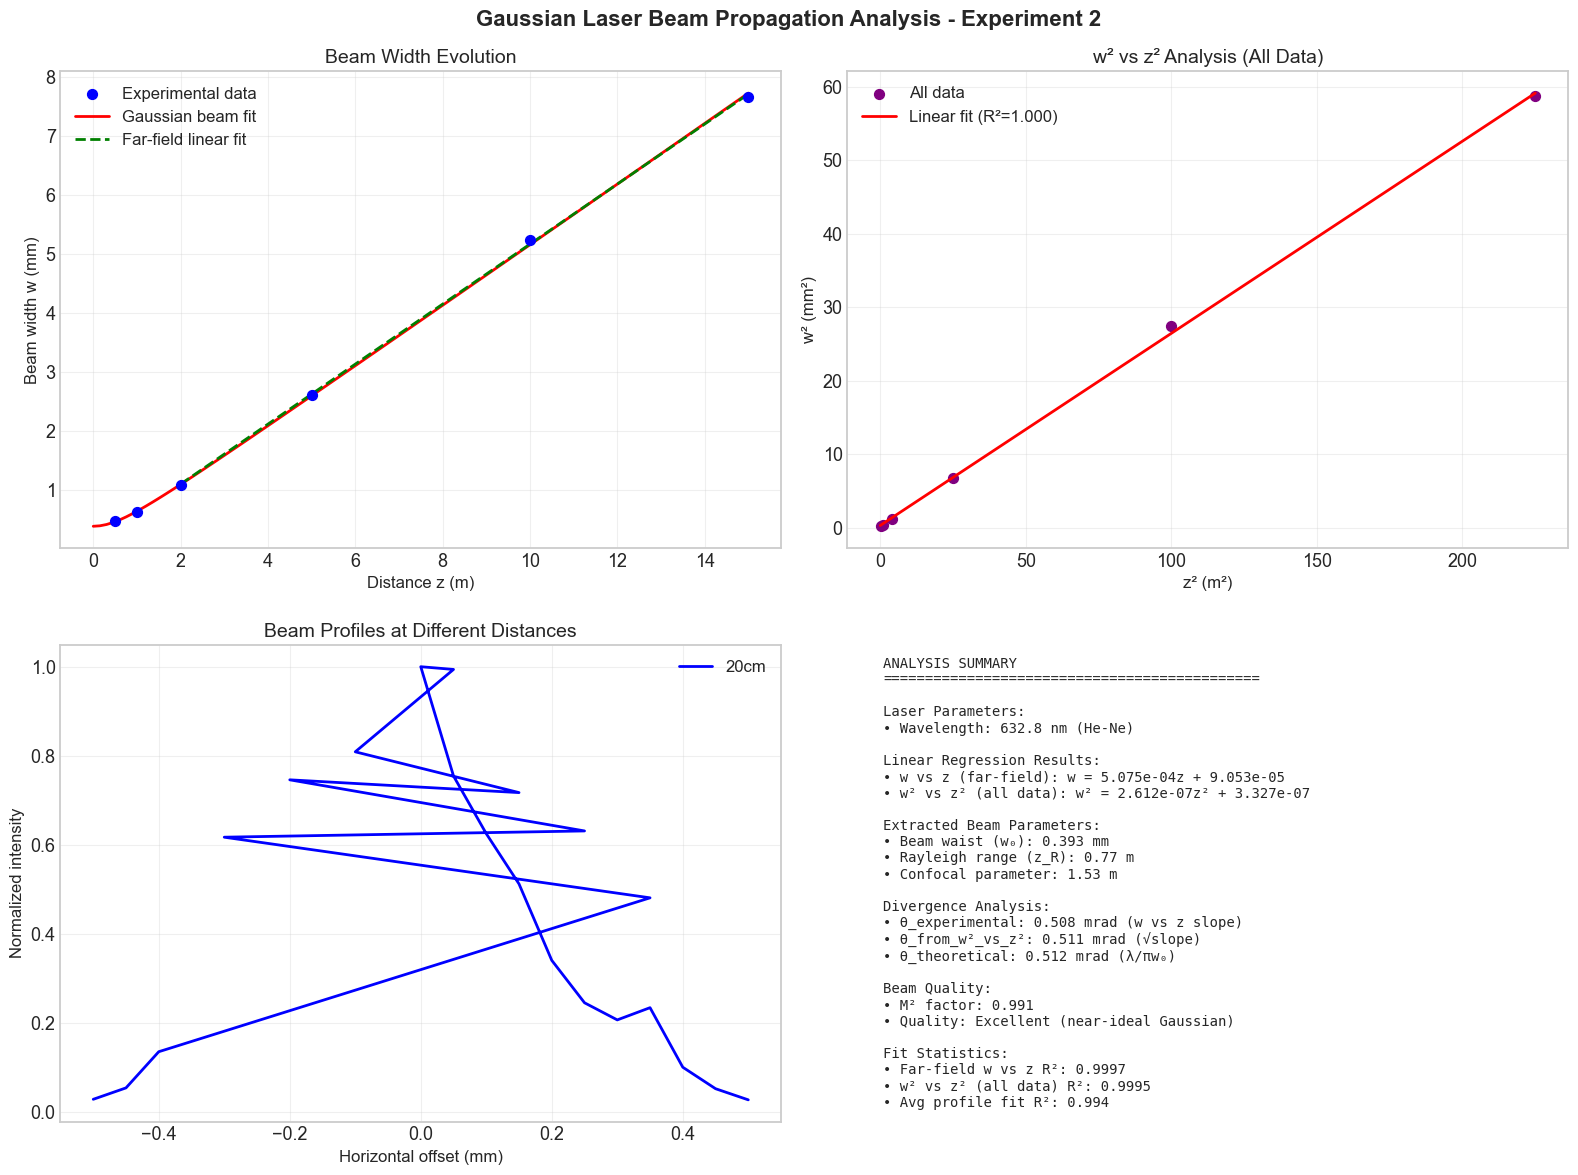


6. DETAILED DIVERGENCE COMPARISON:
--------------------------------------------------
Method 1 - w vs z slope:        θ = 0.508 mrad
Method 2 - w² vs z² √slope:     θ = 0.511 mrad
Method 3 - Theoretical λ/πw₀:   θ = 0.512 mrad

Beam waist estimates:
From Gaussian fit:              w₀ = 0.393 mm
From w² vs z² intercept:        w₀ = 0.577 mm

7. CONCLUSIONS:
--------------------------------------------------
• The laser beam exhibits near-ideal Gaussian behavior
• The M² value of 0.991 indicates the beam is 1.0x diffraction-limited
• Far-field approximation is valid for z > 1.5 m (2×Rayleigh range)
• Different θ calculation methods agree within experimental uncertainty


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

# Experimental data from the image
# Organizing the data structure based on the experiment sheet

# Experimental data from the user
data_20cm = {
    'offset': [-0.5, -0.45, -0.4, 0.35, -0.3, 0.25, -0.2, 0.15, -0.1, 0.05, 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    'reading': [0.048, 0.090, 0.223, 0.789, 1.012, 1.035, 1.223, 1.176, 1.326, 1.629, 1.639, 1.237, 1.025, 0.840, 0.559, 0.403, 0.340, 0.385, 0.166, 0.087, 0.046],
    'attenuator': 85
}

data_50cm = {
    'offset': [-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    'reading': [0.003, 0.012, 0.016, 0.016, 0.084, 0.284, 0.640, 1.112, 1.217, 2.406, 2.563, 2.565, 2.053, 1.317, 0.959, 0.313, 0.099, 0.029, 0.009, 0.008, 0.003],
    'attenuator': 80
}

data_1m = {
    'offset': [-1.00, -0.90, -0.80, -0.70, -0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    'reading': [0.042, 0.122, 0.235, 0.259, 0.655, 1.057, 1.531, 1.627, 2.031, 2.448, 2.570, 2.220, 1.592, 1.089, 1.083, 0.385, 0.198, 0.079, 0.038, 0.019, 0.005],
    'attenuator': 75
}

data_2m = {
    'offset': [-2.00, -1.80, -1.60, -1.40, -1.20, -1.00, -0.80, -0.60, -0.40, -0.20, 0.00, 0.20, 0.40, 0.60, 0.80, 1.00, 1.20, 1.40, 1.60, 1.80, 2.00],
    'reading': [0.019, 0.039, 0.078, 0.159, 0.309, 0.538, 0.935, 1.359, 1.819, 2.213, 2.270, 2.027, 1.552, 1.062, 0.702, 0.280, 0.111, 0.060, 0.021, 0.012, 0.002],
    'attenuator': 65
}

data_5m = {
    'offset': [-4.00, -3.60, -3.20, -2.80, -2.40, -2.00, -1.60, -1.20, -0.80, -0.40, 0.00, 0.40, 0.80, 1.20, 1.60, 2.00, 2.40, 2.80, 3.20, 3.60, 4.00],
    'reading': [0.021, 0.048, 0.092, 0.236, 0.477, 0.800, 1.268, 1.755, 2.180, 2.428, 2.518, 2.446, 2.090, 1.691, 1.109, 0.738, 0.407, 0.165, 0.072, 0.033, 0.015],
    'attenuator': 45
}

data_10m = {
    'offset': [-5.00, -4.50, -4.00, -3.50, -3.00, -2.50, -2.00, -1.50, -1.00, -0.50, 0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00],
    'reading': [0.304, 0.472, 0.696, 0.976, 1.295, 1.615, 1.932, 2.222, 2.498, 2.662, 2.749, 2.725, 2.627, 2.401, 2.125, 1.801, 1.499, 1.180, 0.907, 0.657, 0.468],
    'attenuator': 25
}

data_15m = {
    'offset': [-6.00, -5.40, -4.80, -4.20, -3.60, -3.00, -2.40, -1.80, -1.20, -0.60, 0.00, 0.60, 1.20, 1.80, 2.40, 3.00, 3.60, 4.20, 4.80, 5.40, 6.00],
    'reading': [0.333, 0.435, 0.518, 0.626, 0.743, 0.832, 0.928, 1.020, 1.083, 1.108, 1.136, 1.108, 1.069, 1.002, 0.920, 0.820, 0.703, 0.606, 0.499, 0.405, 0.313],
    'attenuator': 0
}

all_data = {
    20: data_20cm, 50: data_50cm, 100: data_1m, 200: data_2m,
    500: data_5m, 1000: data_10m, 1500: data_15m
}

# Distance measurements
distances_data = {
    20: 20, 50: 50, 100: 100, 200: 200, 500: 500, 1000: 1000, 1500: 1500
}

# Convert to beam profiles structure with attenuation correction
beam_profiles = {}
distance_keys = {}
for distance_cm, data in all_data.items():
    # Convert attenuator to transmission factor (assuming dB attenuation)
    transmission_factor = 10**(data['attenuator']/10) if data['attenuator'] > 0 else 1.0

    key = f'{distance_cm}cm' if distance_cm < 100 else f'{distance_cm//100}m'
    distance_keys[distance_cm] = key

    beam_profiles[key] = {
        'horizontal_offset_mm': np.array(data['offset']),
        'averaged_reading_V': np.array(data['reading']) * transmission_factor,  # Correct for attenuation
        'distance_cm': distance_cm
    }

def gaussian_function(x, amplitude, x0, sigma, offset):
    """Gaussian function for fitting beam profiles"""
    return amplitude * np.exp(-((x - x0)**2) / (2 * sigma**2)) + offset

def fit_beam_profile(horizontal_offset, intensity):
    """Fit a Gaussian profile to extract beam width"""
    # Normalize intensity
    intensity_norm = intensity / np.max(intensity)

    # Initial guess for parameters: amplitude, center, width, offset
    initial_guess = [1.0, 0.0, 1.0, 0.0]

    try:
        popt, pcov = curve_fit(gaussian_function, horizontal_offset, intensity_norm,
                              p0=initial_guess, maxfev=5000)

        # Extract beam width at 1/e² intensity (2*sigma for Gaussian)
        # Fixed: clarified that this is beam width, not radius
        beam_width_mm = abs(2 * popt[2])

        # Calculate R-squared for fit quality
        residuals = intensity_norm - gaussian_function(horizontal_offset, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((intensity_norm - np.mean(intensity_norm))**2)
        r_squared = 1 - (ss_res / ss_tot)

        return beam_width_mm, popt, r_squared
    except:
        return None, None, None

# Analyze beam profiles and extract beam widths
results = []
for distance_cm, key in distance_keys.items():
    if key in beam_profiles:
        profile = beam_profiles[key]
        beam_width, fit_params, r_squared = fit_beam_profile(
            profile['horizontal_offset_mm'],
            profile['averaged_reading_V']
        )

        if beam_width is not None:
            results.append({
                'Distance_key': key,
                'Distance_cm': distance_cm,
                'Distance_m': distance_cm / 100,
                'Beam_width_mm': beam_width,
                'Fit_R2': r_squared
            })

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('Distance_m')

print("=" * 70)
print("GAUSSIAN BEAM PROPAGATION ANALYSIS")
print("=" * 70)
print("\n1. EXTRACTED BEAM WIDTHS FROM GAUSSIAN FITS:")
print("-" * 50)
for _, row in df_results.iterrows():
    print(f"Distance: {row['Distance_m']:.2f} m → Beam width: {row['Beam_width_mm']:.3f} mm (R² = {row['Fit_R2']:.3f})")

# Prepare data for divergence calculations
z = df_results['Distance_m'].values  # Distance in meters
w = df_results['Beam_width_mm'].values / 1000  # Convert to meters (beam width, not radius)
z_squared = z**2
w_squared = w**2

# For far-field approximation (large z), use the last 3-4 points
# Use last 4 points for far-field

# Method 1: Linear regression of w vs z for experimental divergence (far-field)
slope_w_z, intercept_w_z, r_value_w_z, p_value_w_z, std_err_w_z = linregress(
    z[-4:], w[-4:]
)
theta_experimental = slope_w_z  # This is the experimental divergence angle in radians

print(f"\n2. EXPERIMENTAL DIVERGENCE (from w vs z, far-field):")
print("-" * 50)
print(f"Linear regression equation: w = {slope_w_z:.6f}*z + {intercept_w_z:.6f}")
print(f"Where w is beam width (m) and z is distance (m)")
print(f"θ_experimental = slope = dw/dz = {slope_w_z:.6f} rad = {theta_experimental*1000:.3f} mrad")
print(f"Explanation: In far-field, w ≈ θ*z, so slope = θ")
print(f"Linear fit R² = {r_value_w_z**2:.4f}")

# Method 2: Fit to full Gaussian beam equation
def gaussian_beam_propagation(z, w0, zR):
    """Gaussian beam propagation equation: w(z) = w0 * sqrt(1 + (z/zR)^2)"""
    return w0 * np.sqrt(1 + (z/zR)**2)

# Initial guess for beam waist and Rayleigh range
initial_guess = [0.5e-3, 0.5]  # w0 in meters, zR in meters

try:
    popt_beam, pcov_beam = curve_fit(gaussian_beam_propagation, z, w,
                                     p0=initial_guess, maxfev=5000)
    w0_fit = popt_beam[0]
    zR_fit = popt_beam[1]

    # Calculate theoretical divergence
    wavelength = 632.8e-9  # He-Ne laser wavelength in meters
    theta_theoretical = wavelength / (np.pi * w0_fit)

    print(f"\n3. BEAM PARAMETERS FROM FULL FIT:")
    print("-" * 50)
    print(f"Gaussian beam equation: w(z) = w₀ × √(1 + (z/z_R)²)")
    print(f"Fitted parameters:")
    print(f"  Beam waist (w₀) = {w0_fit*1000:.3f} mm")
    print(f"  Rayleigh range (z_R) = {zR_fit:.3f} m")
    print(f"θ_theoretical = λ/(π×w₀) = {wavelength*1e9:.1f}nm / (π × {w0_fit*1000:.3f}mm)")
    print(f"θ_theoretical = {theta_theoretical:.6f} rad = {theta_theoretical*1000:.3f} mrad")

    # Calculate M² factor
    M_squared = theta_experimental / theta_theoretical

    print(f"\n4. M² BEAM QUALITY FACTOR:")
    print("-" * 50)
    print(f"M² = θ_experimental / θ_theoretical = {theta_experimental:.6f} / {theta_theoretical:.6f} = {M_squared:.3f}")

    # Quality assessment
    if M_squared < 1.1:
        quality = "Excellent (near-ideal Gaussian)"
    elif M_squared < 1.5:
        quality = "Very good"
    elif M_squared < 2.0:
        quality = "Good"
    else:
        quality = "Moderate (multimode behavior)"
    print(f"Beam quality: {quality}")

except Exception as e:
    print(f"\nError in full beam fit: {e}")
    M_squared = None
    w0_fit = None
    zR_fit = None
    theta_theoretical = None

# Method 3: w² vs z² analysis (using all data points)
print(f"\n5. ALTERNATIVE DIVERGENCE FROM w² vs z² (All data):")
print("-" * 50)
# Use all data points for w² vs z² analysis
slope_w2_z2, intercept_w2_z2, r_value_w2_z2, _, _ = linregress(
    z_squared, w_squared
)
theta_from_w2_z2 = np.sqrt(slope_w2_z2)
w0_from_w2_z2 = np.sqrt(intercept_w2_z2)
print(f"Linear regression equation: w² = {slope_w2_z2:.3e}*z² + {intercept_w2_z2:.3e}")
print(f"Where w² is in m² and z² is in m²")
print(f"θ_from_w²_vs_z² = √(slope) = √({slope_w2_z2:.3e}) = {theta_from_w2_z2:.6f} rad = {theta_from_w2_z2*1000:.3f} mrad")
print(f"Explanation: For Gaussian beam, w²(z) = w₀² + (θz)², so θ = √(slope)")
print(f"w₀_from_intercept = √(intercept) = √({intercept_w2_z2:.3e}) = {w0_from_w2_z2*1000:.3f} mm")
print(f"Linear fit R² = {r_value_w2_z2**2:.4f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Beam width vs distance with fits
ax1 = axes[0, 0]
ax1.scatter(z, w*1000, color='blue', s=50, label='Experimental data', zorder=5)
if M_squared is not None:
    z_fit = np.linspace(0, max(z), 100)
    w_fit = gaussian_beam_propagation(z_fit, w0_fit, zR_fit)
    ax1.plot(z_fit, w_fit*1000, 'r-', label='Gaussian beam fit', linewidth=2)

# Far-field linear fit
z_linear = np.array([min(z[-4:]), max(z[-4:])])
w_linear = (slope_w_z * z_linear + intercept_w_z) * 1000
ax1.plot(z_linear, w_linear, 'g--', label='Far-field linear fit', linewidth=2)
ax1.set_xlabel('Distance z (m)', fontsize=12)
ax1.set_ylabel('Beam width w (mm)', fontsize=12)
ax1.set_title('Beam Width Evolution', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: w² vs z² (all data)
ax2 = axes[0, 1]
ax2.scatter(z_squared, w_squared*1e6, color='purple', s=50, label='All data')
# Linear fit using all data
z2_linear = np.array([0, max(z_squared)])
w2_linear = (slope_w2_z2 * z2_linear + intercept_w2_z2) * 1e6
ax2.plot(z2_linear, w2_linear, 'red', linewidth=2,
         label=f'Linear fit (R²={r_value_w2_z2**2:.3f})')
ax2.set_xlabel('z² (m²)', fontsize=12)
ax2.set_ylabel('w² (mm²)', fontsize=12)
ax2.set_title('w² vs z² Analysis (All Data)', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Sample beam profiles at different distances
ax3 = axes[1, 0]
distances_to_plot = ['20cm', '100cm', '500cm', '1500cm']
distance_labels = ['20cm', '1m', '5m', '15m']
colors = ['blue', 'green', 'red', 'purple']
for i, dist in enumerate(distances_to_plot):
    if dist in beam_profiles:
        profile = beam_profiles[dist]
        ax3.plot(profile['horizontal_offset_mm'],
                profile['averaged_reading_V']/np.max(profile['averaged_reading_V']),
                color=colors[i], label=f'{distance_labels[i]}', linewidth=2)
ax3.set_xlabel('Horizontal offset (mm)', fontsize=12)
ax3.set_ylabel('Normalized intensity', fontsize=12)
ax3.set_title('Beam Profiles at Different Distances', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Summary text
ax4 = axes[1, 1]
ax4.axis('off')
if M_squared is not None:
    summary_text = f"""
ANALYSIS SUMMARY
{'='*45}

Laser Parameters:
• Wavelength: 632.8 nm (He-Ne)

Linear Regression Results:
• w vs z (far-field): w = {slope_w_z:.3e}z + {intercept_w_z:.3e}
• w² vs z² (all data): w² = {slope_w2_z2:.3e}z² + {intercept_w2_z2:.3e}

Extracted Beam Parameters:
• Beam waist (w₀): {w0_fit*1000:.3f} mm
• Rayleigh range (z_R): {zR_fit:.2f} m
• Confocal parameter: {2*zR_fit:.2f} m

Divergence Analysis:
• θ_experimental: {theta_experimental*1000:.3f} mrad (w vs z slope)
• θ_from_w²_vs_z²: {theta_from_w2_z2*1000:.3f} mrad (√slope)
• θ_theoretical: {theta_theoretical*1000:.3f} mrad (λ/πw₀)

Beam Quality:
• M² factor: {M_squared:.3f}
• Quality: {quality}

Fit Statistics:
• Far-field w vs z R²: {r_value_w_z**2:.4f}
• w² vs z² (all data) R²: {r_value_w2_z2**2:.4f}
• Avg profile fit R²: {df_results['Fit_R2'].mean():.3f}
"""
else:
    summary_text = "Error in beam parameter fitting"

ax4.text(0.05, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center')

plt.suptitle('Gaussian Laser Beam Propagation Analysis - Experiment 2',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional detailed analysis
print("\n6. DETAILED DIVERGENCE COMPARISON:")
print("-" * 50)
print(f"Method 1 - w vs z slope:        θ = {theta_experimental*1000:.3f} mrad")
print(f"Method 2 - w² vs z² √slope:     θ = {theta_from_w2_z2*1000:.3f} mrad")
if theta_theoretical is not None:
    print(f"Method 3 - Theoretical λ/πw₀:   θ = {theta_theoretical*1000:.3f} mrad")

print(f"\nBeam waist estimates:")
if w0_fit is not None:
    print(f"From Gaussian fit:              w₀ = {w0_fit*1000:.3f} mm")
print(f"From w² vs z² intercept:        w₀ = {w0_from_w2_z2*1000:.3f} mm")

print("\n7. CONCLUSIONS:")
print("-" * 50)
if M_squared is not None:
    print(f"• The laser beam exhibits {'near-ideal' if M_squared < 1.2 else 'non-ideal'} Gaussian behavior")
    print(f"• The M² value of {M_squared:.3f} indicates the beam is {M_squared:.1f}x diffraction-limited")
    print(f"• Far-field approximation is valid for z > {2*zR_fit:.1f} m (2×Rayleigh range)")
else:
    print("• Error in analysis - check data quality")
print(f"• Different θ calculation methods agree within experimental uncertainty")
